In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(463113, 828)
(463113, 1)
validation
(87055, 828)
(87055, 1)
test
(43409, 828)
(43409, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 58s - loss: 0.1669 - STD: 1.7413e-04 - MAE: 0.3944

 4/47 [=>............................] - ETA: 1s - loss: 0.0581 - STD: 2.7545e-04 - MAE: 0.1865 

 5/47 [==>...........................] - ETA: 1s - loss: 0.0511 - STD: 2.4272e-04 - MAE: 0.1720

 6/47 [==>...........................] - ETA: 1s - loss: 0.0470 - STD: 2.1343e-04 - MAE: 0.1642

 7/47 [===>..........................] - ETA: 1s - loss: 0.0444 - STD: 1.8884e-04 - MAE: 0.1597

 8/47 [====>.........................] - ETA: 1s - loss: 0.0427 - STD: 1.6841e-04 - MAE: 0.1573

 9/47 [====>.........................] - ETA: 1s - loss: 0.0414 - STD: 1.5140e-04 - MAE: 0.1553

10/47 [=====>........................] - ETA: 1s - loss: 0.0403 - STD: 1.3707e-04 - MAE: 0.1538

11/47 [======>.......................] - ETA: 1s - loss: 0.0396 - STD: 1.2511e-04 - MAE: 0.1527

12/47 [======>.......................] - ETA: 1s - loss: 0.0388 - STD: 1.1537e-04 - MAE: 0.1514

13/47 [=======>......................] - ETA: 1s - loss: 0.0381 - STD: 1.0740e-04 - MAE: 0.1501

14/47 [=======>......................] - ETA: 1s - loss: 0.0373 - STD: 1.0095e-04 - MAE: 0.1487

15/47 [========>.....................] - ETA: 1s - loss: 0.0366 - STD: 9.5641e-05 - MAE: 0.1471

16/47 [=========>....................] - ETA: 1s - loss: 0.0358 - STD: 9.1305e-05 - MAE: 0.1453

17/47 [=========>....................] - ETA: 1s - loss: 0.0350 - STD: 8.7834e-05 - MAE: 0.1433

18/47 [==========>...................] - ETA: 1s - loss: 0.0342 - STD: 8.5150e-05 - MAE: 0.1410

19/47 [===========>..................] - ETA: 1s - loss: 0.0333 - STD: 8.3070e-05 - MAE: 0.1386

20/47 [===========>..................] - ETA: 1s - loss: 0.0325 - STD: 8.1443e-05 - MAE: 0.1362

21/47 [============>.................] - ETA: 1s - loss: 0.0316 - STD: 8.0198e-05 - MAE: 0.1337

22/47 [=============>................] - ETA: 1s - loss: 0.0307 - STD: 7.9172e-05 - MAE: 0.1314

23/47 [=============>................] - ETA: 1s - loss: 0.0299 - STD: 7.8403e-05 - MAE: 0.1294

24/47 [==============>...............] - ETA: 1s - loss: 0.0292 - STD: 7.7541e-05 - MAE: 0.1277

25/47 [==============>...............] - ETA: 1s - loss: 0.0290 - STD: 7.6750e-05 - MAE: 0.1263

29/47 [=================>............] - ETA: 1s - loss: 0.0269 - STD: 7.3192e-05 - MAE: 0.1231

30/47 [==================>...........] - ETA: 1s - loss: 0.0265 - STD: 7.2140e-05 - MAE: 0.1224

31/47 [==================>...........] - ETA: 1s - loss: 0.0261 - STD: 7.0994e-05 - MAE: 0.1217

32/47 [===================>..........] - ETA: 1s - loss: 0.0257 - STD: 6.9862e-05 - MAE: 0.1208

33/47 [====================>.........] - ETA: 0s - loss: 0.0253 - STD: 6.8659e-05 - MAE: 0.1200

34/47 [====================>.........] - ETA: 0s - loss: 0.0249 - STD: 6.7471e-05 - MAE: 0.1190

35/47 [=====================>........] - ETA: 0s - loss: 0.0245 - STD: 6.6317e-05 - MAE: 0.1181

36/47 [=====================>........] - ETA: 0s - loss: 0.0242 - STD: 6.5087e-05 - MAE: 0.1171

37/47 [======================>.......] - ETA: 0s - loss: 0.0238 - STD: 6.3944e-05 - MAE: 0.1162

38/47 [=======================>......] - ETA: 0s - loss: 0.0235 - STD: 6.2812e-05 - MAE: 0.1153

39/47 [=======================>......] - ETA: 0s - loss: 0.0233 - STD: 6.1740e-05 - MAE: 0.1145

40/47 [========================>.....] - ETA: 0s - loss: 0.0230 - STD: 6.0688e-05 - MAE: 0.1137

41/47 [=========================>....] - ETA: 0s - loss: 0.0227 - STD: 5.9687e-05 - MAE: 0.1129

42/47 [=========================>....] - ETA: 0s - loss: 0.0225 - STD: 5.8722e-05 - MAE: 0.1122

43/47 [==========================>...] - ETA: 0s - loss: 0.0223 - STD: 5.7788e-05 - MAE: 0.1116

44/47 [===========================>..] - ETA: 0s - loss: 0.0220 - STD: 5.6880e-05 - MAE: 0.1109

45/47 [===========================>..] - ETA: 0s - loss: 0.0218 - STD: 5.6046e-05 - MAE: 0.1103

46/47 [============================>.] - ETA: 0s - loss: 0.0216 - STD: 5.5239e-05 - MAE: 0.1097

47/47 [==============================] - ETA: 0s - loss: 0.0214 - STD: 5.4462e-05 - MAE: 0.1092

47/47 [==============================] - 5s 83ms/step - loss: 0.0214 - STD: 5.4462e-05 - MAE: 0.1092 - val_loss: 0.0143 - val_STD: 2.1600e-05 - val_MAE: 0.0920


Epoch 2/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0121 - STD: 2.0053e-05 - MAE: 0.0841

 2/47 [>.............................] - ETA: 3s - loss: 0.0121 - STD: 1.9630e-05 - MAE: 0.0846

 3/47 [>.............................] - ETA: 2s - loss: 0.0121 - STD: 2.0542e-05 - MAE: 0.0852

 4/47 [=>............................] - ETA: 2s - loss: 0.0121 - STD: 2.0235e-05 - MAE: 0.0858

 5/47 [==>...........................] - ETA: 2s - loss: 0.0122 - STD: 2.0469e-05 - MAE: 0.0863

 6/47 [==>...........................] - ETA: 2s - loss: 0.0122 - STD: 2.0795e-05 - MAE: 0.0866

 7/47 [===>..........................] - ETA: 2s - loss: 0.0122 - STD: 2.1042e-05 - MAE: 0.0870

 8/47 [====>.........................] - ETA: 2s - loss: 0.0122 - STD: 2.1075e-05 - MAE: 0.0873

 9/47 [====>.........................] - ETA: 2s - loss: 0.0122 - STD: 2.1008e-05 - MAE: 0.0874

10/47 [=====>........................] - ETA: 2s - loss: 0.0122 - STD: 2.1172e-05 - MAE: 0.0875

11/47 [======>.......................] - ETA: 2s - loss: 0.0122 - STD: 2.1300e-05 - MAE: 0.0876

12/47 [======>.......................] - ETA: 2s - loss: 0.0122 - STD: 2.1242e-05 - MAE: 0.0874

13/47 [=======>......................] - ETA: 2s - loss: 0.0122 - STD: 2.1224e-05 - MAE: 0.0873

14/47 [=======>......................] - ETA: 2s - loss: 0.0122 - STD: 2.1157e-05 - MAE: 0.0873

15/47 [========>.....................] - ETA: 2s - loss: 0.0122 - STD: 2.1110e-05 - MAE: 0.0871

16/47 [=========>....................] - ETA: 2s - loss: 0.0122 - STD: 2.1032e-05 - MAE: 0.0870

17/47 [=========>....................] - ETA: 1s - loss: 0.0122 - STD: 2.1099e-05 - MAE: 0.0868

19/47 [===========>..................] - ETA: 1s - loss: 0.0122 - STD: 2.1048e-05 - MAE: 0.0866

20/47 [===========>..................] - ETA: 1s - loss: 0.0122 - STD: 2.1069e-05 - MAE: 0.0865

21/47 [============>.................] - ETA: 1s - loss: 0.0122 - STD: 2.1067e-05 - MAE: 0.0863

22/47 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 2.1088e-05 - MAE: 0.0862

23/47 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 2.1105e-05 - MAE: 0.0861

24/47 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 2.1146e-05 - MAE: 0.0861

25/47 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 2.1222e-05 - MAE: 0.0859

26/47 [===============>..............] - ETA: 1s - loss: 0.0121 - STD: 2.1229e-05 - MAE: 0.0859

27/47 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 2.1313e-05 - MAE: 0.0859

28/47 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 2.1406e-05 - MAE: 0.0859

29/47 [=================>............] - ETA: 1s - loss: 0.0121 - STD: 2.1445e-05 - MAE: 0.0859

30/47 [==================>...........] - ETA: 1s - loss: 0.0121 - STD: 2.1497e-05 - MAE: 0.0859

31/47 [==================>...........] - ETA: 1s - loss: 0.0121 - STD: 2.1536e-05 - MAE: 0.0859

32/47 [===================>..........] - ETA: 0s - loss: 0.0121 - STD: 2.1580e-05 - MAE: 0.0859

33/47 [====================>.........] - ETA: 0s - loss: 0.0121 - STD: 2.1628e-05 - MAE: 0.0859

34/47 [====================>.........] - ETA: 0s - loss: 0.0121 - STD: 2.1700e-05 - MAE: 0.0859

35/47 [=====================>........] - ETA: 0s - loss: 0.0121 - STD: 2.1771e-05 - MAE: 0.0859

36/47 [=====================>........] - ETA: 0s - loss: 0.0121 - STD: 2.1869e-05 - MAE: 0.0859

37/47 [======================>.......] - ETA: 0s - loss: 0.0121 - STD: 2.1991e-05 - MAE: 0.0859

38/47 [=======================>......] - ETA: 0s - loss: 0.0121 - STD: 2.2082e-05 - MAE: 0.0858

39/47 [=======================>......] - ETA: 0s - loss: 0.0121 - STD: 2.2139e-05 - MAE: 0.0859

40/47 [========================>.....] - ETA: 0s - loss: 0.0121 - STD: 2.2216e-05 - MAE: 0.0858

41/47 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 2.2301e-05 - MAE: 0.0858

42/47 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 2.2378e-05 - MAE: 0.0858

43/47 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 2.2455e-05 - MAE: 0.0857

44/47 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 2.2545e-05 - MAE: 0.0857

45/47 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 2.2632e-05 - MAE: 0.0856

46/47 [============================>.] - ETA: 0s - loss: 0.0121 - STD: 2.2713e-05 - MAE: 0.0856

47/47 [==============================] - ETA: 0s - loss: 0.0121 - STD: 2.2805e-05 - MAE: 0.0856

47/47 [==============================] - 3s 71ms/step - loss: 0.0121 - STD: 2.2805e-05 - MAE: 0.0856 - val_loss: 0.0141 - val_STD: 2.6643e-05 - val_MAE: 0.0922


Epoch 3/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0122 - STD: 2.7409e-05 - MAE: 0.0853

 2/47 [>.............................] - ETA: 3s - loss: 0.0121 - STD: 2.8219e-05 - MAE: 0.0851

 3/47 [>.............................] - ETA: 2s - loss: 0.0121 - STD: 2.8610e-05 - MAE: 0.0851

 4/47 [=>............................] - ETA: 2s - loss: 0.0121 - STD: 2.9155e-05 - MAE: 0.0852

 5/47 [==>...........................] - ETA: 2s - loss: 0.0121 - STD: 2.9581e-05 - MAE: 0.0853

 6/47 [==>...........................] - ETA: 2s - loss: 0.0121 - STD: 2.9909e-05 - MAE: 0.0854

 7/47 [===>..........................] - ETA: 2s - loss: 0.0121 - STD: 3.0174e-05 - MAE: 0.0853

 8/47 [====>.........................] - ETA: 2s - loss: 0.0121 - STD: 3.0391e-05 - MAE: 0.0853

 9/47 [====>.........................] - ETA: 2s - loss: 0.0121 - STD: 3.0535e-05 - MAE: 0.0853

10/47 [=====>........................] - ETA: 2s - loss: 0.0121 - STD: 3.0745e-05 - MAE: 0.0853

11/47 [======>.......................] - ETA: 2s - loss: 0.0121 - STD: 3.0974e-05 - MAE: 0.0854

12/47 [======>.......................] - ETA: 2s - loss: 0.0121 - STD: 3.1253e-05 - MAE: 0.0855

13/47 [=======>......................] - ETA: 2s - loss: 0.0121 - STD: 3.1503e-05 - MAE: 0.0854

14/47 [=======>......................] - ETA: 2s - loss: 0.0121 - STD: 3.1768e-05 - MAE: 0.0854

15/47 [========>.....................] - ETA: 2s - loss: 0.0121 - STD: 3.1990e-05 - MAE: 0.0854

16/47 [=========>....................] - ETA: 2s - loss: 0.0121 - STD: 3.2207e-05 - MAE: 0.0854

17/47 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 3.2417e-05 - MAE: 0.0854

18/47 [==========>...................] - ETA: 1s - loss: 0.0121 - STD: 3.2597e-05 - MAE: 0.0853

19/47 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 3.2811e-05 - MAE: 0.0854

20/47 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 3.3023e-05 - MAE: 0.0854

21/47 [============>.................] - ETA: 1s - loss: 0.0121 - STD: 3.3211e-05 - MAE: 0.0855

22/47 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 3.3411e-05 - MAE: 0.0854

23/47 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 3.3613e-05 - MAE: 0.0855

24/47 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 3.3836e-05 - MAE: 0.0854

25/47 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 3.4075e-05 - MAE: 0.0854

26/47 [===============>..............] - ETA: 1s - loss: 0.0121 - STD: 3.4318e-05 - MAE: 0.0854

27/47 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 3.4513e-05 - MAE: 0.0853

28/47 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 3.4730e-05 - MAE: 0.0853

29/47 [=================>............] - ETA: 1s - loss: 0.0120 - STD: 3.4916e-05 - MAE: 0.0853

30/47 [==================>...........] - ETA: 1s - loss: 0.0120 - STD: 3.5131e-05 - MAE: 0.0853

31/47 [==================>...........] - ETA: 1s - loss: 0.0120 - STD: 3.5364e-05 - MAE: 0.0853

32/47 [===================>..........] - ETA: 1s - loss: 0.0120 - STD: 3.5581e-05 - MAE: 0.0852

33/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 3.5803e-05 - MAE: 0.0852

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 3.6031e-05 - MAE: 0.0852

35/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 3.6273e-05 - MAE: 0.0852

36/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 3.6537e-05 - MAE: 0.0852

37/47 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 3.6829e-05 - MAE: 0.0852

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 3.7139e-05 - MAE: 0.0852

39/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 3.7461e-05 - MAE: 0.0851

40/47 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 3.7796e-05 - MAE: 0.0852

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 3.8480e-05 - MAE: 0.0852

43/47 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 3.8828e-05 - MAE: 0.0852

44/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 3.9172e-05 - MAE: 0.0852

45/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 3.9525e-05 - MAE: 0.0852

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 3.9875e-05 - MAE: 0.0852

47/47 [==============================] - ETA: 0s - loss: 0.0120 - STD: 4.0227e-05 - MAE: 0.0852

47/47 [==============================] - 3s 72ms/step - loss: 0.0120 - STD: 4.0227e-05 - MAE: 0.0852 - val_loss: 0.0140 - val_STD: 5.0341e-05 - val_MAE: 0.0923


Epoch 4/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0118 - STD: 5.7589e-05 - MAE: 0.0843

 2/47 [>.............................] - ETA: 3s - loss: 0.0119 - STD: 5.8310e-05 - MAE: 0.0845

 3/47 [>.............................] - ETA: 2s - loss: 0.0119 - STD: 5.8852e-05 - MAE: 0.0847

 4/47 [=>............................] - ETA: 3s - loss: 0.0119 - STD: 5.9272e-05 - MAE: 0.0845

 5/47 [==>...........................] - ETA: 2s - loss: 0.0119 - STD: 5.9863e-05 - MAE: 0.0845

 6/47 [==>...........................] - ETA: 2s - loss: 0.0119 - STD: 6.0404e-05 - MAE: 0.0846

 7/47 [===>..........................] - ETA: 2s - loss: 0.0120 - STD: 6.1001e-05 - MAE: 0.0846

 8/47 [====>.........................] - ETA: 2s - loss: 0.0120 - STD: 6.1574e-05 - MAE: 0.0847

 9/47 [====>.........................] - ETA: 2s - loss: 0.0120 - STD: 6.2219e-05 - MAE: 0.0847

10/47 [=====>........................] - ETA: 2s - loss: 0.0120 - STD: 6.2982e-05 - MAE: 0.0848

11/47 [======>.......................] - ETA: 2s - loss: 0.0120 - STD: 6.3770e-05 - MAE: 0.0848

12/47 [======>.......................] - ETA: 2s - loss: 0.0120 - STD: 6.4552e-05 - MAE: 0.0849

13/47 [=======>......................] - ETA: 2s - loss: 0.0120 - STD: 6.5345e-05 - MAE: 0.0849

14/47 [=======>......................] - ETA: 2s - loss: 0.0120 - STD: 6.6076e-05 - MAE: 0.0849

15/47 [========>.....................] - ETA: 2s - loss: 0.0120 - STD: 6.6778e-05 - MAE: 0.0849

16/47 [=========>....................] - ETA: 2s - loss: 0.0120 - STD: 6.7507e-05 - MAE: 0.0849

17/47 [=========>....................] - ETA: 2s - loss: 0.0120 - STD: 6.8239e-05 - MAE: 0.0849

18/47 [==========>...................] - ETA: 1s - loss: 0.0120 - STD: 6.8911e-05 - MAE: 0.0849

19/47 [===========>..................] - ETA: 1s - loss: 0.0120 - STD: 6.9575e-05 - MAE: 0.0849

20/47 [===========>..................] - ETA: 1s - loss: 0.0120 - STD: 7.0250e-05 - MAE: 0.0849

21/47 [============>.................] - ETA: 1s - loss: 0.0120 - STD: 7.1005e-05 - MAE: 0.0849

22/47 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 7.1751e-05 - MAE: 0.0849

23/47 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 7.2563e-05 - MAE: 0.0849

24/47 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 7.3383e-05 - MAE: 0.0849

25/47 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 7.4246e-05 - MAE: 0.0850

26/47 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 7.5084e-05 - MAE: 0.0849

27/47 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 7.5935e-05 - MAE: 0.0849

28/47 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 7.6809e-05 - MAE: 0.0849

29/47 [=================>............] - ETA: 1s - loss: 0.0120 - STD: 7.7681e-05 - MAE: 0.0849

30/47 [==================>...........] - ETA: 1s - loss: 0.0120 - STD: 7.8653e-05 - MAE: 0.0849

31/47 [==================>...........] - ETA: 1s - loss: 0.0120 - STD: 7.9638e-05 - MAE: 0.0849

32/47 [===================>..........] - ETA: 1s - loss: 0.0120 - STD: 8.0607e-05 - MAE: 0.0849

33/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 8.1632e-05 - MAE: 0.0850

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 8.2670e-05 - MAE: 0.0850

35/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 8.3713e-05 - MAE: 0.0850

36/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 8.4823e-05 - MAE: 0.0850

37/47 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 8.5895e-05 - MAE: 0.0850

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 8.7029e-05 - MAE: 0.0850

39/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 8.8210e-05 - MAE: 0.0850

41/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 9.0721e-05 - MAE: 0.0851

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 9.2007e-05 - MAE: 0.0851

43/47 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 9.3317e-05 - MAE: 0.0851

44/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 9.4647e-05 - MAE: 0.0851

45/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 9.6034e-05 - MAE: 0.0851

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 9.7428e-05 - MAE: 0.0851

47/47 [==============================] - ETA: 0s - loss: 0.0120 - STD: 9.8870e-05 - MAE: 0.0851

47/47 [==============================] - 3s 72ms/step - loss: 0.0120 - STD: 9.8870e-05 - MAE: 0.0851 - val_loss: 0.0140 - val_STD: 1.3880e-04 - val_MAE: 0.0924


Epoch 5/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0115 - STD: 1.6958e-04 - MAE: 0.0836

 3/47 [>.............................] - ETA: 1s - loss: 0.0119 - STD: 1.7463e-04 - MAE: 0.0852

 4/47 [=>............................] - ETA: 2s - loss: 0.0119 - STD: 1.7751e-04 - MAE: 0.0852

 5/47 [==>...........................] - ETA: 2s - loss: 0.0120 - STD: 1.7994e-04 - MAE: 0.0852

 6/47 [==>...........................] - ETA: 2s - loss: 0.0120 - STD: 1.8256e-04 - MAE: 0.0852

 7/47 [===>..........................] - ETA: 2s - loss: 0.0121 - STD: 1.8522e-04 - MAE: 0.0854

 8/47 [====>.........................] - ETA: 2s - loss: 0.0120 - STD: 1.8779e-04 - MAE: 0.0852

 9/47 [====>.........................] - ETA: 2s - loss: 0.0120 - STD: 1.9062e-04 - MAE: 0.0851

10/47 [=====>........................] - ETA: 2s - loss: 0.0120 - STD: 1.9364e-04 - MAE: 0.0851

11/47 [======>.......................] - ETA: 2s - loss: 0.0121 - STD: 1.9660e-04 - MAE: 0.0852

12/47 [======>.......................] - ETA: 2s - loss: 0.0121 - STD: 1.9976e-04 - MAE: 0.0852

13/47 [=======>......................] - ETA: 2s - loss: 0.0121 - STD: 2.0273e-04 - MAE: 0.0852

14/47 [=======>......................] - ETA: 2s - loss: 0.0121 - STD: 2.0621e-04 - MAE: 0.0852

15/47 [========>.....................] - ETA: 2s - loss: 0.0121 - STD: 2.0965e-04 - MAE: 0.0852

16/47 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 2.1320e-04 - MAE: 0.0852

17/47 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 2.1693e-04 - MAE: 0.0852

18/47 [==========>...................] - ETA: 1s - loss: 0.0121 - STD: 2.2072e-04 - MAE: 0.0852

19/47 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 2.2446e-04 - MAE: 0.0853

20/47 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 2.2835e-04 - MAE: 0.0853

21/47 [============>.................] - ETA: 1s - loss: 0.0121 - STD: 2.3221e-04 - MAE: 0.0852

22/47 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 2.3640e-04 - MAE: 0.0853

23/47 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 2.4065e-04 - MAE: 0.0853

24/47 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 2.4489e-04 - MAE: 0.0853

25/47 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 2.4921e-04 - MAE: 0.0853

26/47 [===============>..............] - ETA: 1s - loss: 0.0121 - STD: 2.5362e-04 - MAE: 0.0853

27/47 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 2.5823e-04 - MAE: 0.0853

28/47 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 2.6303e-04 - MAE: 0.0853

29/47 [=================>............] - ETA: 1s - loss: 0.0121 - STD: 2.6793e-04 - MAE: 0.0853

30/47 [==================>...........] - ETA: 1s - loss: 0.0121 - STD: 2.7290e-04 - MAE: 0.0853

31/47 [==================>...........] - ETA: 1s - loss: 0.0120 - STD: 2.7801e-04 - MAE: 0.0853

32/47 [===================>..........] - ETA: 0s - loss: 0.0120 - STD: 2.8336e-04 - MAE: 0.0852

33/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 2.8876e-04 - MAE: 0.0853

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 2.9449e-04 - MAE: 0.0852

35/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 3.0027e-04 - MAE: 0.0852

36/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 3.0609e-04 - MAE: 0.0851

37/47 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 3.1217e-04 - MAE: 0.0851

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 3.1833e-04 - MAE: 0.0851

39/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 3.2471e-04 - MAE: 0.0851

40/47 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 3.3124e-04 - MAE: 0.0851

41/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 3.3808e-04 - MAE: 0.0851

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 3.4525e-04 - MAE: 0.0851

43/47 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 3.5256e-04 - MAE: 0.0851

44/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 3.6021e-04 - MAE: 0.0851

45/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 3.6801e-04 - MAE: 0.0851

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 3.7619e-04 - MAE: 0.0851

47/47 [==============================] - ETA: 0s - loss: 0.0120 - STD: 3.8463e-04 - MAE: 0.0851

47/47 [==============================] - 3s 72ms/step - loss: 0.0120 - STD: 3.8463e-04 - MAE: 0.0851 - val_loss: 0.0139 - val_STD: 6.3535e-04 - val_MAE: 0.0923


Epoch 6/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0118 - STD: 8.0440e-04 - MAE: 0.0847

 2/47 [>.............................] - ETA: 2s - loss: 0.0120 - STD: 8.2427e-04 - MAE: 0.0853

 3/47 [>.............................] - ETA: 2s - loss: 0.0120 - STD: 8.4071e-04 - MAE: 0.0854

 4/47 [=>............................] - ETA: 2s - loss: 0.0120 - STD: 8.5482e-04 - MAE: 0.0853

 5/47 [==>...........................] - ETA: 2s - loss: 0.0119 - STD: 8.7122e-04 - MAE: 0.0850

 6/47 [==>...........................] - ETA: 2s - loss: 0.0119 - STD: 8.8804e-04 - MAE: 0.0849

 7/47 [===>..........................] - ETA: 2s - loss: 0.0119 - STD: 9.0643e-04 - MAE: 0.0849

 8/47 [====>.........................] - ETA: 2s - loss: 0.0119 - STD: 9.2532e-04 - MAE: 0.0848

 9/47 [====>.........................] - ETA: 2s - loss: 0.0119 - STD: 9.4618e-04 - MAE: 0.0847

10/47 [=====>........................] - ETA: 2s - loss: 0.0118 - STD: 9.6660e-04 - MAE: 0.0845

11/47 [======>.......................] - ETA: 2s - loss: 0.0118 - STD: 9.8934e-04 - MAE: 0.0844

12/47 [======>.......................] - ETA: 2s - loss: 0.0118 - STD: 0.0010 - MAE: 0.0845    

13/47 [=======>......................] - ETA: 2s - loss: 0.0118 - STD: 0.0010 - MAE: 0.0845

14/47 [=======>......................] - ETA: 2s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0845

15/47 [========>.....................] - ETA: 2s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0846

16/47 [=========>....................] - ETA: 2s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0846

17/47 [=========>....................] - ETA: 1s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0847

18/47 [==========>...................] - ETA: 1s - loss: 0.0119 - STD: 0.0012 - MAE: 0.0847

19/47 [===========>..................] - ETA: 1s - loss: 0.0119 - STD: 0.0012 - MAE: 0.0846

20/47 [===========>..................] - ETA: 1s - loss: 0.0119 - STD: 0.0012 - MAE: 0.0847

21/47 [============>.................] - ETA: 1s - loss: 0.0119 - STD: 0.0013 - MAE: 0.0847

22/47 [=============>................] - ETA: 1s - loss: 0.0118 - STD: 0.0013 - MAE: 0.0846

23/47 [=============>................] - ETA: 1s - loss: 0.0118 - STD: 0.0013 - MAE: 0.0846

24/47 [==============>...............] - ETA: 1s - loss: 0.0119 - STD: 0.0014 - MAE: 0.0846

25/47 [==============>...............] - ETA: 1s - loss: 0.0119 - STD: 0.0014 - MAE: 0.0846

26/47 [===============>..............] - ETA: 1s - loss: 0.0119 - STD: 0.0015 - MAE: 0.0846

27/47 [================>.............] - ETA: 1s - loss: 0.0119 - STD: 0.0015 - MAE: 0.0846

28/47 [================>.............] - ETA: 1s - loss: 0.0119 - STD: 0.0016 - MAE: 0.0846

29/47 [=================>............] - ETA: 1s - loss: 0.0119 - STD: 0.0016 - MAE: 0.0846

30/47 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 0.0016 - MAE: 0.0846

31/47 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 0.0017 - MAE: 0.0846

32/47 [===================>..........] - ETA: 0s - loss: 0.0118 - STD: 0.0018 - MAE: 0.0845

33/47 [====================>.........] - ETA: 0s - loss: 0.0118 - STD: 0.0018 - MAE: 0.0845

34/47 [====================>.........] - ETA: 0s - loss: 0.0118 - STD: 0.0019 - MAE: 0.0845

35/47 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.0019 - MAE: 0.0845

36/47 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.0020 - MAE: 0.0845

37/47 [======================>.......] - ETA: 0s - loss: 0.0118 - STD: 0.0021 - MAE: 0.0845

38/47 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0021 - MAE: 0.0845

39/47 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0022 - MAE: 0.0845

40/47 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 0.0023 - MAE: 0.0845

41/47 [=========================>....] - ETA: 0s - loss: 0.0118 - STD: 0.0024 - MAE: 0.0845

42/47 [=========================>....] - ETA: 0s - loss: 0.0118 - STD: 0.0025 - MAE: 0.0844

43/47 [==========================>...] - ETA: 0s - loss: 0.0118 - STD: 0.0025 - MAE: 0.0844

44/47 [===========================>..] - ETA: 0s - loss: 0.0118 - STD: 0.0026 - MAE: 0.0844

45/47 [===========================>..] - ETA: 0s - loss: 0.0118 - STD: 0.0027 - MAE: 0.0844

46/47 [============================>.] - ETA: 0s - loss: 0.0118 - STD: 0.0028 - MAE: 0.0844

47/47 [==============================] - 3s 71ms/step - loss: 0.0118 - STD: 0.0029 - MAE: 0.0843 - val_loss: 0.0133 - val_STD: 0.0065 - val_MAE: 0.0900


Epoch 7/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0111 - STD: 0.0083 - MAE: 0.0821

 2/47 [>.............................] - ETA: 3s - loss: 0.0113 - STD: 0.0086 - MAE: 0.0826

 3/47 [>.............................] - ETA: 3s - loss: 0.0113 - STD: 0.0088 - MAE: 0.0827

 4/47 [=>............................] - ETA: 3s - loss: 0.0113 - STD: 0.0090 - MAE: 0.0825

 5/47 [==>...........................] - ETA: 2s - loss: 0.0113 - STD: 0.0092 - MAE: 0.0824

 6/47 [==>...........................] - ETA: 2s - loss: 0.0113 - STD: 0.0095 - MAE: 0.0825

 7/47 [===>..........................] - ETA: 2s - loss: 0.0112 - STD: 0.0098 - MAE: 0.0823

 8/47 [====>.........................] - ETA: 2s - loss: 0.0112 - STD: 0.0101 - MAE: 0.0823

 9/47 [====>.........................] - ETA: 2s - loss: 0.0112 - STD: 0.0104 - MAE: 0.0822

10/47 [=====>........................] - ETA: 2s - loss: 0.0111 - STD: 0.0107 - MAE: 0.0822

11/47 [======>.......................] - ETA: 2s - loss: 0.0111 - STD: 0.0110 - MAE: 0.0821

12/47 [======>.......................] - ETA: 2s - loss: 0.0111 - STD: 0.0113 - MAE: 0.0821

13/47 [=======>......................] - ETA: 2s - loss: 0.0111 - STD: 0.0117 - MAE: 0.0820

14/47 [=======>......................] - ETA: 2s - loss: 0.0110 - STD: 0.0120 - MAE: 0.0819

15/47 [========>.....................] - ETA: 2s - loss: 0.0110 - STD: 0.0124 - MAE: 0.0818

16/47 [=========>....................] - ETA: 2s - loss: 0.0110 - STD: 0.0127 - MAE: 0.0818

18/47 [==========>...................] - ETA: 1s - loss: 0.0110 - STD: 0.0135 - MAE: 0.0816

19/47 [===========>..................] - ETA: 1s - loss: 0.0109 - STD: 0.0139 - MAE: 0.0815

20/47 [===========>..................] - ETA: 1s - loss: 0.0109 - STD: 0.0143 - MAE: 0.0815

21/47 [============>.................] - ETA: 1s - loss: 0.0109 - STD: 0.0147 - MAE: 0.0814

22/47 [=============>................] - ETA: 1s - loss: 0.0109 - STD: 0.0151 - MAE: 0.0813

23/47 [=============>................] - ETA: 1s - loss: 0.0109 - STD: 0.0155 - MAE: 0.0812

24/47 [==============>...............] - ETA: 1s - loss: 0.0108 - STD: 0.0159 - MAE: 0.0811

25/47 [==============>...............] - ETA: 1s - loss: 0.0108 - STD: 0.0163 - MAE: 0.0810

26/47 [===============>..............] - ETA: 1s - loss: 0.0108 - STD: 0.0167 - MAE: 0.0809

27/47 [================>.............] - ETA: 1s - loss: 0.0107 - STD: 0.0171 - MAE: 0.0807

28/47 [================>.............] - ETA: 1s - loss: 0.0107 - STD: 0.0175 - MAE: 0.0806

29/47 [=================>............] - ETA: 1s - loss: 0.0107 - STD: 0.0179 - MAE: 0.0805

30/47 [==================>...........] - ETA: 1s - loss: 0.0107 - STD: 0.0183 - MAE: 0.0805

31/47 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 0.0187 - MAE: 0.0804

32/47 [===================>..........] - ETA: 0s - loss: 0.0106 - STD: 0.0191 - MAE: 0.0803

33/47 [====================>.........] - ETA: 0s - loss: 0.0106 - STD: 0.0195 - MAE: 0.0803

34/47 [====================>.........] - ETA: 0s - loss: 0.0106 - STD: 0.0199 - MAE: 0.0802

35/47 [=====================>........] - ETA: 0s - loss: 0.0106 - STD: 0.0203 - MAE: 0.0800

36/47 [=====================>........] - ETA: 0s - loss: 0.0105 - STD: 0.0207 - MAE: 0.0799

37/47 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 0.0210 - MAE: 0.0798

38/47 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 0.0214 - MAE: 0.0798

39/47 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 0.0218 - MAE: 0.0797

40/47 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 0.0221 - MAE: 0.0796

41/47 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 0.0225 - MAE: 0.0795

42/47 [=========================>....] - ETA: 0s - loss: 0.0104 - STD: 0.0229 - MAE: 0.0795

43/47 [==========================>...] - ETA: 0s - loss: 0.0104 - STD: 0.0232 - MAE: 0.0793

44/47 [===========================>..] - ETA: 0s - loss: 0.0104 - STD: 0.0236 - MAE: 0.0792

45/47 [===========================>..] - ETA: 0s - loss: 0.0104 - STD: 0.0240 - MAE: 0.0791

46/47 [============================>.] - ETA: 0s - loss: 0.0104 - STD: 0.0244 - MAE: 0.0791

47/47 [==============================] - ETA: 0s - loss: 0.0103 - STD: 0.0247 - MAE: 0.0790

47/47 [==============================] - 3s 70ms/step - loss: 0.0103 - STD: 0.0247 - MAE: 0.0790 - val_loss: 0.0112 - val_STD: 0.0339 - val_MAE: 0.0815


Epoch 8/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0095 - STD: 0.0410 - MAE: 0.0755

 2/47 [>.............................] - ETA: 3s - loss: 0.0092 - STD: 0.0413 - MAE: 0.0743

 3/47 [>.............................] - ETA: 2s - loss: 0.0092 - STD: 0.0415 - MAE: 0.0742

 4/47 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 0.0417 - MAE: 0.0737

 5/47 [==>...........................] - ETA: 2s - loss: 0.0091 - STD: 0.0418 - MAE: 0.0734

 6/47 [==>...........................] - ETA: 2s - loss: 0.0091 - STD: 0.0419 - MAE: 0.0735

 7/47 [===>..........................] - ETA: 2s - loss: 0.0091 - STD: 0.0419 - MAE: 0.0734

 8/47 [====>.........................] - ETA: 2s - loss: 0.0091 - STD: 0.0419 - MAE: 0.0733

 9/47 [====>.........................] - ETA: 2s - loss: 0.0091 - STD: 0.0420 - MAE: 0.0732

10/47 [=====>........................] - ETA: 2s - loss: 0.0091 - STD: 0.0421 - MAE: 0.0732

11/47 [======>.......................] - ETA: 2s - loss: 0.0091 - STD: 0.0423 - MAE: 0.0731

12/47 [======>.......................] - ETA: 2s - loss: 0.0090 - STD: 0.0426 - MAE: 0.0730

13/47 [=======>......................] - ETA: 2s - loss: 0.0090 - STD: 0.0428 - MAE: 0.0728

14/47 [=======>......................] - ETA: 2s - loss: 0.0090 - STD: 0.0430 - MAE: 0.0727

15/47 [========>.....................] - ETA: 2s - loss: 0.0089 - STD: 0.0433 - MAE: 0.0726

16/47 [=========>....................] - ETA: 2s - loss: 0.0089 - STD: 0.0435 - MAE: 0.0724

18/47 [==========>...................] - ETA: 1s - loss: 0.0089 - STD: 0.0440 - MAE: 0.0722

19/47 [===========>..................] - ETA: 1s - loss: 0.0088 - STD: 0.0442 - MAE: 0.0720

20/47 [===========>..................] - ETA: 1s - loss: 0.0088 - STD: 0.0444 - MAE: 0.0718

21/47 [============>.................] - ETA: 1s - loss: 0.0087 - STD: 0.0446 - MAE: 0.0716

22/47 [=============>................] - ETA: 1s - loss: 0.0087 - STD: 0.0448 - MAE: 0.0715

23/47 [=============>................] - ETA: 1s - loss: 0.0087 - STD: 0.0452 - MAE: 0.0714

24/47 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 0.0455 - MAE: 0.0712

25/47 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 0.0457 - MAE: 0.0711

26/47 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 0.0462 - MAE: 0.0712

27/47 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0464 - MAE: 0.0710

28/47 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0468 - MAE: 0.0708

29/47 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0473 - MAE: 0.0709

30/47 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0476 - MAE: 0.0707

31/47 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0478 - MAE: 0.0705

32/47 [===================>..........] - ETA: 0s - loss: 0.0084 - STD: 0.0483 - MAE: 0.0705

33/47 [====================>.........] - ETA: 0s - loss: 0.0084 - STD: 0.0488 - MAE: 0.0704

34/47 [====================>.........] - ETA: 0s - loss: 0.0084 - STD: 0.0490 - MAE: 0.0702

35/47 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.0494 - MAE: 0.0701

36/47 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.0498 - MAE: 0.0700

37/47 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.0501 - MAE: 0.0699

38/47 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.0504 - MAE: 0.0697

39/47 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0507 - MAE: 0.0696

40/47 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0511 - MAE: 0.0695

41/47 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0513 - MAE: 0.0694

42/47 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0516 - MAE: 0.0693

43/47 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.0519 - MAE: 0.0693

44/47 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0522 - MAE: 0.0692

45/47 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0524 - MAE: 0.0690

46/47 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0526 - MAE: 0.0690

47/47 [==============================] - ETA: 0s - loss: 0.0081 - STD: 0.0529 - MAE: 0.0689

47/47 [==============================] - 3s 71ms/step - loss: 0.0081 - STD: 0.0529 - MAE: 0.0689 - val_loss: 0.0089 - val_STD: 0.0619 - val_MAE: 0.0721


Epoch 9/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0069 - STD: 0.0624 - MAE: 0.0631

 2/47 [>.............................] - ETA: 2s - loss: 0.0072 - STD: 0.0609 - MAE: 0.0637

 3/47 [>.............................] - ETA: 2s - loss: 0.0072 - STD: 0.0629 - MAE: 0.0644

 4/47 [=>............................] - ETA: 2s - loss: 0.0073 - STD: 0.0640 - MAE: 0.0652

 5/47 [==>...........................] - ETA: 2s - loss: 0.0072 - STD: 0.0635 - MAE: 0.0645

 6/47 [==>...........................] - ETA: 2s - loss: 0.0072 - STD: 0.0631 - MAE: 0.0643

 7/47 [===>..........................] - ETA: 2s - loss: 0.0072 - STD: 0.0638 - MAE: 0.0646

 8/47 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0643 - MAE: 0.0647

 9/47 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0639 - MAE: 0.0644

10/47 [=====>........................] - ETA: 2s - loss: 0.0072 - STD: 0.0638 - MAE: 0.0644

11/47 [======>.......................] - ETA: 2s - loss: 0.0072 - STD: 0.0642 - MAE: 0.0645

12/47 [======>.......................] - ETA: 2s - loss: 0.0072 - STD: 0.0644 - MAE: 0.0644

13/47 [=======>......................] - ETA: 2s - loss: 0.0072 - STD: 0.0642 - MAE: 0.0643

14/47 [=======>......................] - ETA: 2s - loss: 0.0072 - STD: 0.0642 - MAE: 0.0643

15/47 [========>.....................] - ETA: 2s - loss: 0.0072 - STD: 0.0645 - MAE: 0.0644

16/47 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.0646 - MAE: 0.0644

17/47 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.0644 - MAE: 0.0643

18/47 [==========>...................] - ETA: 1s - loss: 0.0072 - STD: 0.0645 - MAE: 0.0643

19/47 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.0646 - MAE: 0.0644

20/47 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.0647 - MAE: 0.0644

21/47 [============>.................] - ETA: 1s - loss: 0.0072 - STD: 0.0646 - MAE: 0.0643

22/47 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0647 - MAE: 0.0643

23/47 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0649 - MAE: 0.0643

24/47 [==============>...............] - ETA: 1s - loss: 0.0071 - STD: 0.0650 - MAE: 0.0642

25/47 [==============>...............] - ETA: 1s - loss: 0.0071 - STD: 0.0650 - MAE: 0.0642

26/47 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0650 - MAE: 0.0641

27/47 [================>.............] - ETA: 1s - loss: 0.0071 - STD: 0.0652 - MAE: 0.0641

29/47 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0653 - MAE: 0.0640

30/47 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0653 - MAE: 0.0640

31/47 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0655 - MAE: 0.0640

32/47 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0655 - MAE: 0.0639

33/47 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0655 - MAE: 0.0639

34/47 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0656 - MAE: 0.0639

35/47 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0656 - MAE: 0.0639

36/47 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0656 - MAE: 0.0639

37/47 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0656 - MAE: 0.0638

38/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0656 - MAE: 0.0638

39/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0657 - MAE: 0.0638

40/47 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0657 - MAE: 0.0637

41/47 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0658 - MAE: 0.0637

42/47 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0658 - MAE: 0.0637

43/47 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0659 - MAE: 0.0636

44/47 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0660 - MAE: 0.0636

45/47 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0660 - MAE: 0.0636

46/47 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0661 - MAE: 0.0636

47/47 [==============================] - ETA: 0s - loss: 0.0070 - STD: 0.0662 - MAE: 0.0635

47/47 [==============================] - 3s 70ms/step - loss: 0.0070 - STD: 0.0662 - MAE: 0.0635 - val_loss: 0.0087 - val_STD: 0.0666 - val_MAE: 0.0697


Epoch 10/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.0665 - MAE: 0.0618

 2/47 [>.............................] - ETA: 3s - loss: 0.0071 - STD: 0.0683 - MAE: 0.0633

 3/47 [>.............................] - ETA: 3s - loss: 0.0070 - STD: 0.0683 - MAE: 0.0634

 4/47 [=>............................] - ETA: 2s - loss: 0.0070 - STD: 0.0677 - MAE: 0.0629

 5/47 [==>...........................] - ETA: 2s - loss: 0.0069 - STD: 0.0674 - MAE: 0.0627

 6/47 [==>...........................] - ETA: 2s - loss: 0.0069 - STD: 0.0678 - MAE: 0.0629

 7/47 [===>..........................] - ETA: 2s - loss: 0.0069 - STD: 0.0676 - MAE: 0.0627

 8/47 [====>.........................] - ETA: 2s - loss: 0.0069 - STD: 0.0674 - MAE: 0.0623

 9/47 [====>.........................] - ETA: 2s - loss: 0.0068 - STD: 0.0675 - MAE: 0.0623

10/47 [=====>........................] - ETA: 2s - loss: 0.0068 - STD: 0.0677 - MAE: 0.0623

11/47 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0676 - MAE: 0.0622

12/47 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0676 - MAE: 0.0621

13/47 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0679 - MAE: 0.0621

14/47 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0680 - MAE: 0.0621

15/47 [========>.....................] - ETA: 2s - loss: 0.0068 - STD: 0.0680 - MAE: 0.0620

16/47 [=========>....................] - ETA: 2s - loss: 0.0068 - STD: 0.0681 - MAE: 0.0620

17/47 [=========>....................] - ETA: 1s - loss: 0.0068 - STD: 0.0682 - MAE: 0.0620

18/47 [==========>...................] - ETA: 1s - loss: 0.0068 - STD: 0.0682 - MAE: 0.0619

19/47 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0682 - MAE: 0.0619

20/47 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0683 - MAE: 0.0619

21/47 [============>.................] - ETA: 1s - loss: 0.0068 - STD: 0.0685 - MAE: 0.0620

22/47 [=============>................] - ETA: 1s - loss: 0.0068 - STD: 0.0685 - MAE: 0.0619

23/47 [=============>................] - ETA: 1s - loss: 0.0068 - STD: 0.0684 - MAE: 0.0618

24/47 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0687 - MAE: 0.0619

25/47 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0687 - MAE: 0.0618

26/47 [===============>..............] - ETA: 1s - loss: 0.0068 - STD: 0.0687 - MAE: 0.0618

27/47 [================>.............] - ETA: 1s - loss: 0.0068 - STD: 0.0688 - MAE: 0.0619

28/47 [================>.............] - ETA: 1s - loss: 0.0068 - STD: 0.0688 - MAE: 0.0618

29/47 [=================>............] - ETA: 1s - loss: 0.0068 - STD: 0.0688 - MAE: 0.0618

30/47 [==================>...........] - ETA: 1s - loss: 0.0068 - STD: 0.0688 - MAE: 0.0618

31/47 [==================>...........] - ETA: 1s - loss: 0.0068 - STD: 0.0689 - MAE: 0.0618

32/47 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0689 - MAE: 0.0617

34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0690 - MAE: 0.0618

35/47 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0690 - MAE: 0.0618

36/47 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0690 - MAE: 0.0618

37/47 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0690 - MAE: 0.0617

38/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0690 - MAE: 0.0617

39/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0691 - MAE: 0.0616

40/47 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0691 - MAE: 0.0616

41/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0691 - MAE: 0.0616

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0692 - MAE: 0.0616

43/47 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0693 - MAE: 0.0615

44/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0693 - MAE: 0.0615

45/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0693 - MAE: 0.0615

46/47 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0694 - MAE: 0.0615

47/47 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0694 - MAE: 0.0615

47/47 [==============================] - 3s 71ms/step - loss: 0.0067 - STD: 0.0694 - MAE: 0.0615 - val_loss: 0.0082 - val_STD: 0.0719 - val_MAE: 0.0681


Epoch 11/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.0703 - MAE: 0.0601

 2/47 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0711 - MAE: 0.0609

 3/47 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0697 - MAE: 0.0604

 4/47 [=>............................] - ETA: 2s - loss: 0.0066 - STD: 0.0694 - MAE: 0.0604

 5/47 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.0702 - MAE: 0.0610

 6/47 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.0702 - MAE: 0.0609

 7/47 [===>..........................] - ETA: 2s - loss: 0.0067 - STD: 0.0698 - MAE: 0.0608

 8/47 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0700 - MAE: 0.0608

 9/47 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0704 - MAE: 0.0610

10/47 [=====>........................] - ETA: 2s - loss: 0.0067 - STD: 0.0704 - MAE: 0.0608

11/47 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0704 - MAE: 0.0607

12/47 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0707 - MAE: 0.0608

13/47 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0707 - MAE: 0.0607

14/47 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0706 - MAE: 0.0607

15/47 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0709 - MAE: 0.0608

16/47 [=========>....................] - ETA: 2s - loss: 0.0066 - STD: 0.0709 - MAE: 0.0607

17/47 [=========>....................] - ETA: 2s - loss: 0.0066 - STD: 0.0708 - MAE: 0.0607

18/47 [==========>...................] - ETA: 1s - loss: 0.0066 - STD: 0.0708 - MAE: 0.0607

19/47 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0710 - MAE: 0.0608

20/47 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0707 - MAE: 0.0608

21/47 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0706 - MAE: 0.0607

22/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0708 - MAE: 0.0608

23/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0708 - MAE: 0.0607

24/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0706 - MAE: 0.0606

25/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0707 - MAE: 0.0607

26/47 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0708 - MAE: 0.0607

27/47 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0706 - MAE: 0.0606

28/47 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0706 - MAE: 0.0606

29/47 [=================>............] - ETA: 1s - loss: 0.0066 - STD: 0.0708 - MAE: 0.0606

30/47 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0708 - MAE: 0.0606

31/47 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0707 - MAE: 0.0605

32/47 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0708 - MAE: 0.0605

33/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0709 - MAE: 0.0606

34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0709 - MAE: 0.0605

35/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0709 - MAE: 0.0605

36/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0710 - MAE: 0.0605

38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0711 - MAE: 0.0605

39/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0711 - MAE: 0.0605

40/47 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0713 - MAE: 0.0605

41/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0713 - MAE: 0.0604

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0712 - MAE: 0.0604

43/47 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0713 - MAE: 0.0604

44/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0713 - MAE: 0.0604

45/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0713 - MAE: 0.0604

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0714 - MAE: 0.0604

47/47 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0714 - MAE: 0.0604

47/47 [==============================] - 3s 71ms/step - loss: 0.0066 - STD: 0.0714 - MAE: 0.0604 - val_loss: 0.0082 - val_STD: 0.0731 - val_MAE: 0.0669


Epoch 12/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0705 - MAE: 0.0585

 2/47 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0706 - MAE: 0.0585

 3/47 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0720 - MAE: 0.0593

 4/47 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0728 - MAE: 0.0594

 5/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0724 - MAE: 0.0591

 6/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0726 - MAE: 0.0594

 7/47 [===>..........................] - ETA: 2s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0600

 8/47 [====>.........................] - ETA: 2s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0597

 9/47 [====>.........................] - ETA: 2s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0597

10/47 [=====>........................] - ETA: 2s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0597

11/47 [======>.......................] - ETA: 2s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0598

12/47 [======>.......................] - ETA: 2s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0596

13/47 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0596

14/47 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0730 - MAE: 0.0597

15/47 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0728 - MAE: 0.0597

16/47 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.0727 - MAE: 0.0596

17/47 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.0727 - MAE: 0.0597

18/47 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0727 - MAE: 0.0597

19/47 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0727 - MAE: 0.0597

20/47 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0728 - MAE: 0.0596

21/47 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0596

23/47 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0729 - MAE: 0.0595

24/47 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0730 - MAE: 0.0594

25/47 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0730 - MAE: 0.0594

26/47 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0730 - MAE: 0.0594

27/47 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0594

28/47 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0594

29/47 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0593

30/47 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0593

31/47 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0732 - MAE: 0.0593

32/47 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0593

33/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0593

34/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0592

35/47 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0592

36/47 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0592

37/47 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0731 - MAE: 0.0592

38/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0732 - MAE: 0.0592

39/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0732 - MAE: 0.0592

40/47 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0732 - MAE: 0.0592

41/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0733 - MAE: 0.0592

42/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0733 - MAE: 0.0592

43/47 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0733 - MAE: 0.0592

44/47 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0733 - MAE: 0.0592

45/47 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0734 - MAE: 0.0592

46/47 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0734 - MAE: 0.0592

47/47 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0734 - MAE: 0.0592

47/47 [==============================] - 3s 72ms/step - loss: 0.0064 - STD: 0.0734 - MAE: 0.0592 - val_loss: 0.0079 - val_STD: 0.0761 - val_MAE: 0.0657


Epoch 13/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.0747 - MAE: 0.0597

 2/47 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0751 - MAE: 0.0593

 3/47 [>.............................] - ETA: 3s - loss: 0.0063 - STD: 0.0737 - MAE: 0.0586

 4/47 [=>............................] - ETA: 2s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0586

 5/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0589

 6/47 [==>...........................] - ETA: 2s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0587

 7/47 [===>..........................] - ETA: 2s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0587

 8/47 [====>.........................] - ETA: 2s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0588

 9/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0589

10/47 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0588

11/47 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0588

12/47 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0588

13/47 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0744 - MAE: 0.0588

14/47 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0587

15/47 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.0744 - MAE: 0.0588

16/47 [=========>....................] - ETA: 2s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0587

17/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0587

18/47 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0744 - MAE: 0.0587

19/47 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0587

20/47 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0586

21/47 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0586

22/47 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0586

23/47 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0585

24/47 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0585

25/47 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0585

26/47 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0585

27/47 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0585

28/47 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0585

29/47 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0584

30/47 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0584

31/47 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0584

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0584

33/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

35/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

37/47 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

39/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0747 - MAE: 0.0583

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0747 - MAE: 0.0583

41/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

43/47 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0747 - MAE: 0.0583

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

45/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0583

47/47 [==============================] - 3s 70ms/step - loss: 0.0062 - STD: 0.0747 - MAE: 0.0584 - val_loss: 0.0079 - val_STD: 0.0751 - val_MAE: 0.0646


Epoch 14/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0719 - MAE: 0.0579

 2/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0736 - MAE: 0.0582

 3/47 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0737 - MAE: 0.0578

 4/47 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0737 - MAE: 0.0579

 5/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0743 - MAE: 0.0582

 6/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0737 - MAE: 0.0581

 7/47 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0743 - MAE: 0.0582

 8/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0744 - MAE: 0.0582

 9/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0741 - MAE: 0.0580

10/47 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0745 - MAE: 0.0582

11/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0741 - MAE: 0.0581

12/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0742 - MAE: 0.0582

13/47 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0742 - MAE: 0.0582

14/47 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0739 - MAE: 0.0581

15/47 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0739 - MAE: 0.0582

16/47 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0738 - MAE: 0.0582

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0739 - MAE: 0.0582

18/47 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0740 - MAE: 0.0581

19/47 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0741 - MAE: 0.0580

20/47 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0744 - MAE: 0.0580

21/47 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0745 - MAE: 0.0579

22/47 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0747 - MAE: 0.0579

23/47 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0580

24/47 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0747 - MAE: 0.0580

25/47 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0581

26/47 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0747 - MAE: 0.0581

27/47 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0581

28/47 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0581

29/47 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0581

30/47 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0580

31/47 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0580

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0580

33/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0749 - MAE: 0.0581

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0581

35/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0580

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0751 - MAE: 0.0580

37/47 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0580

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0580

39/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0580

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0580

41/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0579

43/47 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0751 - MAE: 0.0580

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0752 - MAE: 0.0580

45/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0752 - MAE: 0.0580

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0753 - MAE: 0.0580

47/47 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0752 - MAE: 0.0579

47/47 [==============================] - 3s 70ms/step - loss: 0.0062 - STD: 0.0752 - MAE: 0.0579 - val_loss: 0.0075 - val_STD: 0.0793 - val_MAE: 0.0643


Epoch 15/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.0779 - MAE: 0.0593

 2/47 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0764 - MAE: 0.0582

 3/47 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0749 - MAE: 0.0581

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0751 - MAE: 0.0583

 5/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0748 - MAE: 0.0580

 6/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0581

 7/47 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0578

 8/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0578

 9/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0576

10/47 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0575

11/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0761 - MAE: 0.0575

12/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0764 - MAE: 0.0575

13/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0761 - MAE: 0.0574

14/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0761 - MAE: 0.0575

15/47 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0574

16/47 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0760 - MAE: 0.0574

17/47 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0760 - MAE: 0.0574

19/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0763 - MAE: 0.0575

20/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0575

21/47 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0762 - MAE: 0.0577

22/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0576

23/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0576

24/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0577

25/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0577

26/47 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0577

27/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0578

28/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0578

29/47 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0578

30/47 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0578

31/47 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0578

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0756 - MAE: 0.0579

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0578

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0578

35/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0578

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0754 - MAE: 0.0578

37/47 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0578

38/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0578

39/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0578

40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0578

41/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0578

42/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0577

43/47 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0577

44/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0578

45/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0577

46/47 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0577

47/47 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0577

47/47 [==============================] - 3s 71ms/step - loss: 0.0061 - STD: 0.0757 - MAE: 0.0577 - val_loss: 0.0075 - val_STD: 0.0763 - val_MAE: 0.0633


Epoch 16/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0742 - MAE: 0.0564

 2/47 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0748 - MAE: 0.0570

 3/47 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0761 - MAE: 0.0570

 4/47 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0760 - MAE: 0.0568

 5/47 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0763 - MAE: 0.0567

 6/47 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0766 - MAE: 0.0567

 7/47 [===>..........................] - ETA: 2s - loss: 0.0059 - STD: 0.0766 - MAE: 0.0567

 8/47 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0567

 9/47 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0767 - MAE: 0.0569

10/47 [=====>........................] - ETA: 2s - loss: 0.0060 - STD: 0.0764 - MAE: 0.0569

11/47 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0761 - MAE: 0.0569

12/47 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0760 - MAE: 0.0569

13/47 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0759 - MAE: 0.0569

14/47 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0759 - MAE: 0.0569

15/47 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0761 - MAE: 0.0570

16/47 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0761 - MAE: 0.0570

18/47 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0764 - MAE: 0.0569

19/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0764 - MAE: 0.0569

20/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0764 - MAE: 0.0568

21/47 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0766 - MAE: 0.0569

22/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0569

23/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0766 - MAE: 0.0570

24/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0764 - MAE: 0.0569

25/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0570

26/47 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0569

27/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0764 - MAE: 0.0569

28/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0571

29/47 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0763 - MAE: 0.0570

30/47 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0763 - MAE: 0.0570

31/47 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0571

32/47 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0762 - MAE: 0.0571

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0763 - MAE: 0.0572

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0764 - MAE: 0.0573

35/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0761 - MAE: 0.0572

36/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0572

37/47 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0761 - MAE: 0.0574

38/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0573

39/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0573

40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0575

41/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0575

42/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0575

43/47 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0577

44/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0577

45/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0754 - MAE: 0.0577

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0754 - MAE: 0.0578

47/47 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0754 - MAE: 0.0578

47/47 [==============================] - 3s 70ms/step - loss: 0.0062 - STD: 0.0754 - MAE: 0.0578 - val_loss: 0.0083 - val_STD: 0.0692 - val_MAE: 0.0647


Epoch 17/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0562

 2/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0701 - MAE: 0.0561

 3/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0740 - MAE: 0.0577

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0747 - MAE: 0.0575

 5/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0744 - MAE: 0.0573

 6/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0753 - MAE: 0.0574

 7/47 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0576

 9/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0756 - MAE: 0.0576

10/47 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0758 - MAE: 0.0578

11/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0578

12/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0754 - MAE: 0.0576

13/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0753 - MAE: 0.0576

14/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0578

15/47 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0756 - MAE: 0.0577

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0755 - MAE: 0.0576

17/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0576

18/47 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0761 - MAE: 0.0576

19/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0575

20/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0574

21/47 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0761 - MAE: 0.0575

22/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0760 - MAE: 0.0574

23/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0574

24/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0574

25/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0574

26/47 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0758 - MAE: 0.0573

27/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0573

28/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0573

29/47 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0759 - MAE: 0.0573

30/47 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0760 - MAE: 0.0572

31/47 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0761 - MAE: 0.0572

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0762 - MAE: 0.0572

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0762 - MAE: 0.0572

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0762 - MAE: 0.0572

35/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0762 - MAE: 0.0572

36/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0761 - MAE: 0.0571

37/47 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0761 - MAE: 0.0571

38/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0761 - MAE: 0.0571

39/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0761 - MAE: 0.0571

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0762 - MAE: 0.0571

41/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0762 - MAE: 0.0571

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0763 - MAE: 0.0570

43/47 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0764 - MAE: 0.0570

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0570

45/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0570

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0570

47/47 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0766 - MAE: 0.0570

47/47 [==============================] - 3s 70ms/step - loss: 0.0060 - STD: 0.0766 - MAE: 0.0570 - val_loss: 0.0074 - val_STD: 0.0778 - val_MAE: 0.0622


Epoch 18/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0756 - MAE: 0.0554

 2/47 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0756 - MAE: 0.0553

 3/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0770 - MAE: 0.0561

 5/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0771 - MAE: 0.0562

 6/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0772 - MAE: 0.0562

 7/47 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0773 - MAE: 0.0563

 8/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0773 - MAE: 0.0562

 9/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0775 - MAE: 0.0563

10/47 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0774 - MAE: 0.0563

11/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0774 - MAE: 0.0563

12/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0775 - MAE: 0.0563

13/47 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0563

14/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0773 - MAE: 0.0562

15/47 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0562

16/47 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0563

17/47 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0562

18/47 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0563

19/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0563

20/47 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0563

21/47 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0563

22/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0564

23/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0563

24/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0563

25/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0564

26/47 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0564

27/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0564

28/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0564

29/47 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0564

30/47 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0564

31/47 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0565

32/47 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0564

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0564

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0565

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0564

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0565

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0565

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0565

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0772 - MAE: 0.0565

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0565

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0564

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0564

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0774 - MAE: 0.0564

44/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0774 - MAE: 0.0564

45/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0564

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0774 - MAE: 0.0564

47/47 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0773 - MAE: 0.0564

47/47 [==============================] - 3s 69ms/step - loss: 0.0059 - STD: 0.0773 - MAE: 0.0564 - val_loss: 0.0071 - val_STD: 0.0787 - val_MAE: 0.0618


Epoch 19/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0567

 2/47 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0775 - MAE: 0.0565

 3/47 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0771 - MAE: 0.0563

 4/47 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0773 - MAE: 0.0563

 5/47 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0561

 6/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0776 - MAE: 0.0560

 7/47 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0560

 8/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0560

 9/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0561

10/47 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0560

11/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0559

12/47 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0559

13/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0560

14/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0560

15/47 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0560

16/47 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0560

18/47 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0559

19/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0559

20/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0559

21/47 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0559

22/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0559

23/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0781 - MAE: 0.0559

24/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0559

25/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0559

26/47 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0559

27/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0559

28/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0559

29/47 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0559

30/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0559

31/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0559

32/47 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0559

33/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0560

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0559

35/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0560

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0560

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

38/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0560

39/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

40/47 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

41/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

42/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

43/47 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

44/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

45/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

46/47 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

47/47 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0560

47/47 [==============================] - 3s 70ms/step - loss: 0.0058 - STD: 0.0778 - MAE: 0.0560 - val_loss: 0.0072 - val_STD: 0.0784 - val_MAE: 0.0618


Epoch 20/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0782 - MAE: 0.0548

 2/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0804 - MAE: 0.0561

 3/47 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0788 - MAE: 0.0561

 4/47 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0791 - MAE: 0.0561

 5/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0786 - MAE: 0.0558

 6/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0781 - MAE: 0.0557

 7/47 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0785 - MAE: 0.0558

 8/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0783 - MAE: 0.0555

 9/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0555

10/47 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0784 - MAE: 0.0555

11/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0554

12/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0784 - MAE: 0.0555

13/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0783 - MAE: 0.0554

14/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0555

15/47 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0784 - MAE: 0.0557

16/47 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0557

17/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0557

18/47 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0781 - MAE: 0.0557

19/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0557

20/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0560

21/47 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0560

22/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0559

23/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0561

24/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

25/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0560

26/47 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0778 - MAE: 0.0561

27/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0561

28/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0777 - MAE: 0.0561

29/47 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0778 - MAE: 0.0562

30/47 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0562

32/47 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0777 - MAE: 0.0562

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0562

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0777 - MAE: 0.0562

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0777 - MAE: 0.0562

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0562

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0777 - MAE: 0.0562

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0777 - MAE: 0.0562

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0562

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0561

41/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0776 - MAE: 0.0562

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0561

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0561

44/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0776 - MAE: 0.0561

45/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0776 - MAE: 0.0561

46/47 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0776 - MAE: 0.0561

47/47 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0776 - MAE: 0.0561

47/47 [==============================] - 3s 69ms/step - loss: 0.0058 - STD: 0.0776 - MAE: 0.0561 - val_loss: 0.0072 - val_STD: 0.0803 - val_MAE: 0.0616


Epoch 21/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0800 - MAE: 0.0554

 2/47 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0798 - MAE: 0.0554

 3/47 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0793 - MAE: 0.0552

 4/47 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0789 - MAE: 0.0551

 5/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0789 - MAE: 0.0553

 6/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0555

 7/47 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0789 - MAE: 0.0555

 8/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0792 - MAE: 0.0556

 9/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0788 - MAE: 0.0555

10/47 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0792 - MAE: 0.0556

11/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0555

12/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0788 - MAE: 0.0554

13/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0790 - MAE: 0.0557

14/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0787 - MAE: 0.0557

15/47 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0786 - MAE: 0.0557

16/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0787 - MAE: 0.0558

17/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0785 - MAE: 0.0557

18/47 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0785 - MAE: 0.0557

19/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0786 - MAE: 0.0558

20/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0557

21/47 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0558

22/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0784 - MAE: 0.0559

23/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0559

24/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0559

25/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0560

26/47 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0779 - MAE: 0.0560

27/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0560

28/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0780 - MAE: 0.0561

29/47 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0560

30/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0560

31/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0778 - MAE: 0.0561

32/47 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0776 - MAE: 0.0560

33/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0776 - MAE: 0.0560

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0778 - MAE: 0.0562

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0562

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0561

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0776 - MAE: 0.0563

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0774 - MAE: 0.0561

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0562

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0562

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0774 - MAE: 0.0562

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0562

44/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0562

45/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0562

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0562

47/47 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0775 - MAE: 0.0562

47/47 [==============================] - 3s 68ms/step - loss: 0.0059 - STD: 0.0775 - MAE: 0.0562 - val_loss: 0.0073 - val_STD: 0.0772 - val_MAE: 0.0618


Epoch 22/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0760 - MAE: 0.0553

 2/47 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0771 - MAE: 0.0551

 3/47 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0552

 4/47 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0784 - MAE: 0.0552

 5/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0788 - MAE: 0.0551

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0549

 7/47 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0793 - MAE: 0.0550

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0549

 9/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0550

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0550

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0550

12/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0551

13/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0551

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0550

15/47 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0787 - MAE: 0.0550

16/47 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0788 - MAE: 0.0550

17/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0788 - MAE: 0.0550

18/47 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0788 - MAE: 0.0550

19/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0551

20/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0550

21/47 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0789 - MAE: 0.0550

22/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0551

23/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0550

24/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0550

25/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0550

26/47 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0789 - MAE: 0.0550

28/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0550

29/47 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0550

30/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0550

31/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0550

32/47 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0549

33/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0550

34/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0792 - MAE: 0.0550

35/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0550

36/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0550

37/47 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0550

38/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0550

39/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0550

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0550

41/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0550

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0550

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0550

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0550

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0550

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0791 - MAE: 0.0550

47/47 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0549

47/47 [==============================] - 3s 71ms/step - loss: 0.0057 - STD: 0.0790 - MAE: 0.0549 - val_loss: 0.0070 - val_STD: 0.0794 - val_MAE: 0.0611


Epoch 23/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0786 - MAE: 0.0546

 2/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0551

 3/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0783 - MAE: 0.0547

 4/47 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0550

 5/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0549

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0548

 7/47 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0800 - MAE: 0.0552

 8/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0793 - MAE: 0.0551

 9/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0792 - MAE: 0.0552

10/47 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0794 - MAE: 0.0552

11/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0789 - MAE: 0.0552

12/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0793 - MAE: 0.0554

13/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0789 - MAE: 0.0553

14/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0787 - MAE: 0.0552

15/47 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0790 - MAE: 0.0555

16/47 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0785 - MAE: 0.0555

17/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0786 - MAE: 0.0556

18/47 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0556

19/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0556

20/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0784 - MAE: 0.0558

21/47 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0557

22/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0781 - MAE: 0.0556

23/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0556

24/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0556

25/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0781 - MAE: 0.0556

26/47 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0556

27/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0556

28/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0555

29/47 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0784 - MAE: 0.0556

30/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0555

31/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0783 - MAE: 0.0555

32/47 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0784 - MAE: 0.0556

33/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0556

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0556

35/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0556

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0781 - MAE: 0.0555

37/47 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0780 - MAE: 0.0555

38/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0556

39/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0781 - MAE: 0.0556

40/47 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0555

41/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0555

42/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0782 - MAE: 0.0555

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0555

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0783 - MAE: 0.0555

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0783 - MAE: 0.0555

47/47 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0784 - MAE: 0.0555

47/47 [==============================] - 3s 70ms/step - loss: 0.0057 - STD: 0.0784 - MAE: 0.0555 - val_loss: 0.0071 - val_STD: 0.0803 - val_MAE: 0.0611


Epoch 24/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0786 - MAE: 0.0533

 2/47 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0791 - MAE: 0.0539

 3/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0805 - MAE: 0.0546

 4/47 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0800 - MAE: 0.0546

 5/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0799 - MAE: 0.0543

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0803 - MAE: 0.0548

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0799 - MAE: 0.0546

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

 9/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0549

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0546

13/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0546

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0546

15/47 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0547

16/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0547

17/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0546

18/47 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0548

19/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

20/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

21/47 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0548

22/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0547

23/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0547

24/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0548

25/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0788 - MAE: 0.0547

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0547

27/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

28/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0547

29/47 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0547

30/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

31/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0547

32/47 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

36/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

38/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0547

39/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

40/47 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

41/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0548

42/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0547

44/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0547

45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

46/47 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

47/47 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

47/47 [==============================] - 3s 71ms/step - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547 - val_loss: 0.0070 - val_STD: 0.0806 - val_MAE: 0.0612


Epoch 25/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0551

 2/47 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0801 - MAE: 0.0553

 3/47 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0785 - MAE: 0.0548

 4/47 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0549

 5/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0549

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0547

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0799 - MAE: 0.0547

 8/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0798 - MAE: 0.0545

10/47 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0544

11/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0543

12/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0544

13/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0798 - MAE: 0.0545

14/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0544

15/47 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0798 - MAE: 0.0544

16/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0798 - MAE: 0.0544

17/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0543

18/47 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0543

19/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0543

20/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0543

21/47 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0544

22/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0543

23/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0544

24/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0544

25/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0543

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0543

27/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0543

28/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0543

29/47 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0544

30/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0543

31/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0543

32/47 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0798 - MAE: 0.0543

33/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0543

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0544

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0543

36/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0544

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0543

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0543

39/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0544

40/47 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0544

41/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0544

42/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0544

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0544

44/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0545

45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

46/47 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0544

47/47 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

47/47 [==============================] - 3s 69ms/step - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545 - val_loss: 0.0076 - val_STD: 0.0747 - val_MAE: 0.0618


Epoch 26/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0744 - MAE: 0.0534

 2/47 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0782 - MAE: 0.0540

 3/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0545

 4/47 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0545

 5/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0797 - MAE: 0.0550

 6/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0794 - MAE: 0.0548

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0545

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0547

 9/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0546

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0546

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

12/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0546

13/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0547

15/47 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0546

16/47 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0546

17/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0546

18/47 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0546

19/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0547

20/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0546

22/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0546

23/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

24/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0545

25/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0545

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

27/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0545

28/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0545

29/47 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0545

30/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0545

31/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0545

32/47 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0545

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0546

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

36/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0546

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

38/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0546

39/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

40/47 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

41/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0545

42/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0544

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0544

44/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0544

45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0544

46/47 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0544

47/47 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0544

47/47 [==============================] - 3s 70ms/step - loss: 0.0056 - STD: 0.0795 - MAE: 0.0544 - val_loss: 0.0074 - val_STD: 0.0759 - val_MAE: 0.0612


Epoch 27/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0752 - MAE: 0.0542

 2/47 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0794 - MAE: 0.0548

 3/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0799 - MAE: 0.0543

 4/47 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0541

 5/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0801 - MAE: 0.0545

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0543

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0545

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0545

 9/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0545

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0544

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0543

12/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0543

13/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0544

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0543

15/47 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0542

16/47 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0799 - MAE: 0.0542

17/47 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0797 - MAE: 0.0542

18/47 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0799 - MAE: 0.0542

19/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0542

20/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0541

21/47 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0541

22/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0540

23/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0799 - MAE: 0.0540

24/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0541

25/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0799 - MAE: 0.0541

26/47 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0541

27/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0542

28/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0542

29/47 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0801 - MAE: 0.0541

30/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0801 - MAE: 0.0541

31/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0801 - MAE: 0.0540

32/47 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0540

33/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0540

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

36/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0540

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0539

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0539

41/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0539

42/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0539

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0539

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0539

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0539

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0539

47/47 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0538

47/47 [==============================] - 3s 71ms/step - loss: 0.0055 - STD: 0.0802 - MAE: 0.0538 - val_loss: 0.0069 - val_STD: 0.0850 - val_MAE: 0.0615


Epoch 28/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0849 - MAE: 0.0543

 2/47 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0817 - MAE: 0.0543

 3/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0546

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0816 - MAE: 0.0540

 5/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0812 - MAE: 0.0538

 6/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0815 - MAE: 0.0545

 7/47 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0543

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0807 - MAE: 0.0546

 9/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0806 - MAE: 0.0545

10/47 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0543

11/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0807 - MAE: 0.0545

12/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0544

13/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0543

14/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0544

15/47 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0543

16/47 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0544

17/47 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0543

18/47 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0543

19/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0801 - MAE: 0.0543

20/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0543

21/47 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0801 - MAE: 0.0542

22/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0801 - MAE: 0.0543

23/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0801 - MAE: 0.0542

24/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0801 - MAE: 0.0542

25/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0542

26/47 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0541

27/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0542

28/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0541

29/47 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0541

30/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

31/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

32/47 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

33/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

36/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0540

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0540

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0539

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0539

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0539

41/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0539

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0538

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0539

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0539

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0538

47/47 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0539

47/47 [==============================] - 3s 71ms/step - loss: 0.0055 - STD: 0.0804 - MAE: 0.0539 - val_loss: 0.0070 - val_STD: 0.0804 - val_MAE: 0.0602


Epoch 29/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0785 - MAE: 0.0525

 2/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0794 - MAE: 0.0531

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0535

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0798 - MAE: 0.0533

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0537

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0535

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0535

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0536

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

10/47 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0536

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0536

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0535

13/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

14/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0535

15/47 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0534

16/47 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0536

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0536

19/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0536

20/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0536

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0536

22/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0536

23/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0802 - MAE: 0.0536

24/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

26/47 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0536

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0535

28/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0535

29/47 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0535

30/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0535

31/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0535

32/47 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0535

33/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0535

35/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0536

36/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0535

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0535

38/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0536

39/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0536

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0536

41/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0536

42/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0535

44/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0535

45/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

47/47 [==============================] - 3s 70ms/step - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535 - val_loss: 0.0069 - val_STD: 0.0811 - val_MAE: 0.0604


Epoch 30/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0799 - MAE: 0.0534

 2/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0530

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0818 - MAE: 0.0531

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0825 - MAE: 0.0534

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0817 - MAE: 0.0531

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0818 - MAE: 0.0534

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0534

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0534

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0533

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0533

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0815 - MAE: 0.0534

14/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

15/47 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0533

16/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0532

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0534

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0534

19/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0535

20/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0534

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0534

22/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0534

23/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0534

24/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

25/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

26/47 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

28/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

29/47 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

30/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0533

31/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0533

32/47 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0534

33/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0534

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0534

35/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0535

36/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0536

38/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0536

39/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0536

41/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0536

42/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0536

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0536

44/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0536

45/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0536

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0536

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

47/47 [==============================] - 3s 71ms/step - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535 - val_loss: 0.0069 - val_STD: 0.0839 - val_MAE: 0.0609


Epoch 31/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0539

 2/47 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0791 - MAE: 0.0534

 3/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0815 - MAE: 0.0544

 4/47 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0806 - MAE: 0.0540

 5/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0807 - MAE: 0.0538

 6/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0810 - MAE: 0.0540

 7/47 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0806 - MAE: 0.0537

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0536

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0536

10/47 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0535

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0537

12/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0810 - MAE: 0.0537

13/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0811 - MAE: 0.0537

14/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0810 - MAE: 0.0537

15/47 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0536

16/47 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0536

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0534

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0534

19/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0534

20/47 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0534

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

22/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0533

23/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0533

24/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0533

25/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0532

26/47 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0532

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

28/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0532

29/47 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

30/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

31/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

32/47 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

33/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0532

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

36/47 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0533

38/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

39/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0531

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0531

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0531

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0531

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0532

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532

47/47 [==============================] - 3s 71ms/step - loss: 0.0054 - STD: 0.0810 - MAE: 0.0532 - val_loss: 0.0068 - val_STD: 0.0831 - val_MAE: 0.0606


Epoch 32/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0535

 2/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0792 - MAE: 0.0527

 3/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0534

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0531

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0811 - MAE: 0.0532

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0533

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0531

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0533

 9/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0532

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0530

11/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0531

12/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0530

13/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

14/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0530

16/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0530

17/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0530

18/47 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0529

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0529

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0529

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0529

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0529

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0530

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0530

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0531

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0531

27/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0531

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0531

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0531

30/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0531

31/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0530

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0530

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0530

38/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0530

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0530

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0529

47/47 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

47/47 [==============================] - 3s 71ms/step - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530 - val_loss: 0.0070 - val_STD: 0.0804 - val_MAE: 0.0598


Epoch 33/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0798 - MAE: 0.0518

 2/47 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0807 - MAE: 0.0517

 3/47 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0806 - MAE: 0.0517

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0814 - MAE: 0.0520

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0808 - MAE: 0.0519

 6/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0814 - MAE: 0.0521

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0810 - MAE: 0.0521

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0522

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0522

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0524

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0810 - MAE: 0.0524

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0525

13/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0525

14/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0810 - MAE: 0.0525

15/47 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0527

16/47 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0527

17/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0527

18/47 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0527

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0527

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0529

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0529

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0529

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0529

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0528

27/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0529

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0529

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0529

30/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0529

31/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0529

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0529

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0528

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0528

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0528

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0528

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0528

38/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0528

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0528

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0528

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0529

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

47/47 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0531

47/47 [==============================] - 3s 70ms/step - loss: 0.0053 - STD: 0.0813 - MAE: 0.0531 - val_loss: 0.0068 - val_STD: 0.0837 - val_MAE: 0.0601


Epoch 34/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0807 - MAE: 0.0522

 2/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0802 - MAE: 0.0519

 3/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0828 - MAE: 0.0528

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0525

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0525

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0530

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0531

 9/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0530

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0528

11/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0528

12/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0528

13/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0527

14/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0529

15/47 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0528

16/47 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0528

17/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0529

18/47 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0528

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0528

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0528

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0527

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0526

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0526

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0526

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0527

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0526

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0526

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0526

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0526

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0526

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0526

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0526

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

47/47 [==============================] - 3s 71ms/step - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526 - val_loss: 0.0067 - val_STD: 0.0821 - val_MAE: 0.0600


Epoch 35/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0806 - MAE: 0.0520

 2/47 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0528

 3/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0802 - MAE: 0.0526

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0535

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0532

 6/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0530

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0530

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0528

 9/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0530

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

11/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0529

12/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0530

13/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0528

14/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0529

15/47 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0528

16/47 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0528

17/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0528

18/47 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0527

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0527

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0528

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0529

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0529

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0529

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0528

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0529

27/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0529

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0529

30/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0530

31/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0529

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0530

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0529

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0528

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0528

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0527

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0527

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0527

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0527

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0526

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0526

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

47/47 [==============================] - 3s 70ms/step - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526 - val_loss: 0.0067 - val_STD: 0.0842 - val_MAE: 0.0603


Epoch 36/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0519

 2/47 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0520

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0820 - MAE: 0.0519

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0523

 5/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0522

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0527

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0525

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0524

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0523

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0524

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0524

13/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

14/47 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0523

15/47 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

16/47 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

20/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0522

21/47 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0523

22/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0522

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0523

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0522

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0522

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0522

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0523

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0524

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0524

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0524

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

47/47 [==============================] - 3s 71ms/step - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523 - val_loss: 0.0067 - val_STD: 0.0853 - val_MAE: 0.0602


Epoch 37/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0855 - MAE: 0.0523

 3/47 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0518

 4/47 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0530

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0825 - MAE: 0.0530

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0831 - MAE: 0.0533

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0828 - MAE: 0.0532

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0823 - MAE: 0.0530

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0828 - MAE: 0.0533

10/47 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0822 - MAE: 0.0532

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0824 - MAE: 0.0531

12/47 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0530

13/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0529

14/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0529

15/47 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0528

16/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0527

17/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0527

18/47 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0526

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0825 - MAE: 0.0527

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0526

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0526

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0527

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0823 - MAE: 0.0526

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0526

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0525

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0525

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0525

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0524

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0524

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0524

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0523

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0523

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0523

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0522

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0522

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0522

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0522

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0522

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0522

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0522

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0522

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0521

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0521

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0521

47/47 [==============================] - 3s 70ms/step - loss: 0.0052 - STD: 0.0823 - MAE: 0.0521 - val_loss: 0.0067 - val_STD: 0.0796 - val_MAE: 0.0590


Epoch 38/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0510

 2/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0522

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0805 - MAE: 0.0521

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0806 - MAE: 0.0519

 5/47 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0522

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0521

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0827 - MAE: 0.0527

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0525

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0524

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0527

13/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0527

14/47 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0527

15/47 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0526

16/47 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0815 - MAE: 0.0526

17/47 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0527

18/47 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0526

19/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525

20/47 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

21/47 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0524

22/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0525

23/47 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0524

24/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0524

25/47 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0524

26/47 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0819 - MAE: 0.0523

27/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

28/47 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0522

29/47 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0522

30/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0522

31/47 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0522

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0523

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0523

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0523

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0524

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0524

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0524

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0524

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0525

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0820 - MAE: 0.0525

47/47 [==============================] - 3s 70ms/step - loss: 0.0052 - STD: 0.0820 - MAE: 0.0525 - val_loss: 0.0069 - val_STD: 0.0861 - val_MAE: 0.0622


Epoch 39/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0870 - MAE: 0.0559

 2/47 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0799 - MAE: 0.0555

 3/47 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0551

 4/47 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0823 - MAE: 0.0545

 5/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0538

 6/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0809 - MAE: 0.0539

 7/47 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0813 - MAE: 0.0538

 8/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0537

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0536

10/47 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0536

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0809 - MAE: 0.0534

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0533

13/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0812 - MAE: 0.0533

14/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0808 - MAE: 0.0532

15/47 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0531

17/47 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0531

18/47 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0530

19/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0530

20/47 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

21/47 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0529

22/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0530

23/47 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0530

24/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

25/47 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0529

26/47 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0529

27/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0528

28/47 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0528

29/47 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0528

30/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0527

31/47 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0527

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0527

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0527

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0527

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0526

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0526

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0526

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0524

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525

47/47 [==============================] - 3s 71ms/step - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525 - val_loss: 0.0069 - val_STD: 0.0886 - val_MAE: 0.0623


Epoch 40/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0891 - MAE: 0.0551

 2/47 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0820 - MAE: 0.0537

 3/47 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0822 - MAE: 0.0531

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0835 - MAE: 0.0538

 5/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0814 - MAE: 0.0538

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0819 - MAE: 0.0535

 7/47 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0830 - MAE: 0.0542

 8/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0816 - MAE: 0.0543

 9/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0814 - MAE: 0.0540

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0823 - MAE: 0.0549

11/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0809 - MAE: 0.0551

12/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0803 - MAE: 0.0548

13/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0808 - MAE: 0.0559

14/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0801 - MAE: 0.0556

15/47 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0794 - MAE: 0.0555

16/47 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0803 - MAE: 0.0560

17/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0802 - MAE: 0.0557

18/47 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0797 - MAE: 0.0556

19/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0796 - MAE: 0.0554

20/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0798 - MAE: 0.0556

21/47 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0795 - MAE: 0.0553

23/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0794 - MAE: 0.0552

24/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0797 - MAE: 0.0550

25/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0795 - MAE: 0.0549

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0795 - MAE: 0.0548

27/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0548

28/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0797 - MAE: 0.0547

29/47 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0546

30/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0796 - MAE: 0.0545

31/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0545

32/47 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0798 - MAE: 0.0544

33/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0798 - MAE: 0.0543

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0798 - MAE: 0.0542

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0799 - MAE: 0.0542

36/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0542

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0541

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0800 - MAE: 0.0541

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0541

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0540

41/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0540

42/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0540

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0539

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0538

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0803 - MAE: 0.0538

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0538

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0804 - MAE: 0.0537

47/47 [==============================] - 3s 70ms/step - loss: 0.0054 - STD: 0.0804 - MAE: 0.0537 - val_loss: 0.0070 - val_STD: 0.0781 - val_MAE: 0.0594


Epoch 41/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0512

 2/47 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0797 - MAE: 0.0516

 3/47 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0812 - MAE: 0.0524

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0807 - MAE: 0.0519

 5/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0802 - MAE: 0.0517

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0810 - MAE: 0.0522

 7/47 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0812 - MAE: 0.0523

 8/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0808 - MAE: 0.0521

 9/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0810 - MAE: 0.0520

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0813 - MAE: 0.0520

11/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0812 - MAE: 0.0519

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0811 - MAE: 0.0519

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0814 - MAE: 0.0520

14/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0813 - MAE: 0.0518

15/47 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0812 - MAE: 0.0518

16/47 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0814 - MAE: 0.0518

17/47 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0518

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0814 - MAE: 0.0517

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0816 - MAE: 0.0517

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0517

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0517

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0817 - MAE: 0.0517

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0517

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0819 - MAE: 0.0517

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0518

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0518

28/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0517

29/47 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0517

30/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0517

31/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0517

32/47 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0517

33/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0517

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0517

35/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0517

36/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0517

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0516

38/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0516

39/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0516

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0516

41/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0516

42/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0516

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

44/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

45/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

47/47 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

47/47 [==============================] - 3s 71ms/step - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516 - val_loss: 0.0066 - val_STD: 0.0824 - val_MAE: 0.0591


Epoch 42/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0506

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0513

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0511

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0823 - MAE: 0.0510

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0513

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0512

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0511

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0515

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0514

11/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0516

12/47 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0516

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0516

14/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0517

15/47 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0516

16/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0516

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0517

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0516

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0516

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0518

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0518

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0517

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0518

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0518

25/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0518

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0518

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0518

28/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0518

29/47 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

30/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0519

31/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0519

32/47 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0520

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0520

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0520

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0523

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0522

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0522

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0524

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0523

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0523

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0524

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0524

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

44/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0524

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

47/47 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524

47/47 [==============================] - 3s 67ms/step - loss: 0.0052 - STD: 0.0822 - MAE: 0.0524 - val_loss: 0.0070 - val_STD: 0.0884 - val_MAE: 0.0635


Epoch 43/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0886 - MAE: 0.0558

 2/47 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0846 - MAE: 0.0536

 3/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0528

 4/47 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0527

 5/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0529

 6/47 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0525

 7/47 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0819 - MAE: 0.0522

 8/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0523

 9/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0523

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0522

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0522

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0523

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0522

14/47 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0820 - MAE: 0.0521

15/47 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0521

16/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0521

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0520

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0519

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0520

20/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0519

21/47 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0519

22/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0518

23/47 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0519

24/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0518

25/47 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0518

26/47 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0518

27/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0518

28/47 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0518

29/47 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0518

30/47 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0518

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0517

32/47 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0517

33/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0517

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0517

35/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0517

36/47 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0517

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0517

38/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0517

39/47 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0516

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0517

41/47 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

44/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0516

45/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0516

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0824 - MAE: 0.0515

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0516

47/47 [==============================] - 3s 63ms/step - loss: 0.0050 - STD: 0.0825 - MAE: 0.0516 - val_loss: 0.0068 - val_STD: 0.0829 - val_MAE: 0.0588


Epoch 44/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0816 - MAE: 0.0509

 2/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0509

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0836 - MAE: 0.0512

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0829 - MAE: 0.0510

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0508

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0511

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0510

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0510

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0512

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0511

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0511

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0512

13/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0511

14/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0829 - MAE: 0.0511

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0511

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0511

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0511

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0511

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0510

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0511

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0511

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0510

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0511

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0511

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0511

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0510

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0510

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0511

30/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0511

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0511

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

35/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0510

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0510

38/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0510

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0510

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0509

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0509

47/47 [==============================] - 3s 62ms/step - loss: 0.0050 - STD: 0.0835 - MAE: 0.0509 - val_loss: 0.0066 - val_STD: 0.0850 - val_MAE: 0.0587


Epoch 45/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0508

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0508

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0510

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0510

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0512

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0510

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0510

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0513

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0512

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0513

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0513

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0511

13/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0511

14/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0511

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0510

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0510

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0509

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0509

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0510

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0510

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0509

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0510

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0509

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0509

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0509

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0509

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0509

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0509

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0509

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0509

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0509

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0509

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0509

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0509

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0509

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0509

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0509

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0509

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0509

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0509

47/47 [==============================] - 3s 62ms/step - loss: 0.0050 - STD: 0.0835 - MAE: 0.0509 - val_loss: 0.0066 - val_STD: 0.0871 - val_MAE: 0.0597


Epoch 46/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0520

 2/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0849 - MAE: 0.0515

 3/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0842 - MAE: 0.0514

 4/47 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0515

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0512

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0511

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0510

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0510

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0509

11/47 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

12/47 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0509

13/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0508

14/47 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0509

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0509

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0508

17/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0509

18/47 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0509

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0509

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0509

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0509

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0510

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0510

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0509

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0510

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0510

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0511

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0511

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

30/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0511

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0511

32/47 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0512

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0511

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0511

35/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0511

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0511

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0511

38/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0511

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0509

47/47 [==============================] - 3s 64ms/step - loss: 0.0050 - STD: 0.0836 - MAE: 0.0509 - val_loss: 0.0066 - val_STD: 0.0871 - val_MAE: 0.0591


Epoch 47/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0505

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0502

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0505

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0506

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0506

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0506

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0505

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0507

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0506

13/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0507

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0506

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0506

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0506

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0506

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0506

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0506

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0505

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0505

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0506

30/47 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0507

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0507

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0507

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0507

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0507

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0509

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0508

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0508

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0508

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0509

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0509

47/47 [==============================] - 3s 64ms/step - loss: 0.0049 - STD: 0.0838 - MAE: 0.0509 - val_loss: 0.0066 - val_STD: 0.0842 - val_MAE: 0.0584


Epoch 48/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0499

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0857 - MAE: 0.0514

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0509

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0845 - MAE: 0.0514

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0510

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0510

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0512

 8/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0511

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0512

10/47 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0511

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0509

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0510

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0509

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0509

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0509

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0508

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0507

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0507

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0506

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0506

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0506

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0506

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0506

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0506

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0507

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0507

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0507

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0507

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0508

47/47 [==============================] - 3s 65ms/step - loss: 0.0049 - STD: 0.0839 - MAE: 0.0508 - val_loss: 0.0066 - val_STD: 0.0849 - val_MAE: 0.0585


Epoch 49/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0497

 2/47 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0821 - MAE: 0.0501

 3/47 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0514

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0512

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0513

 6/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

 7/47 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0512

 8/47 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0840 - MAE: 0.0516

 9/47 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0514

10/47 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0514

11/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0515

12/47 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0828 - MAE: 0.0513

13/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0512

14/47 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0512

15/47 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0511

16/47 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0511

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0510

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0510

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0832 - MAE: 0.0509

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0510

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0509

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0509

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0509

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0509

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0509

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0508

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0508

30/47 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0508

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0508

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0508

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0508

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0508

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0509

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0508

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0508

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0508

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0508

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0508

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0508

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0508

47/47 [==============================] - 3s 65ms/step - loss: 0.0049 - STD: 0.0836 - MAE: 0.0508 - val_loss: 0.0066 - val_STD: 0.0842 - val_MAE: 0.0584


Epoch 50/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0833 - MAE: 0.0495

 2/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0832 - MAE: 0.0498

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0828 - MAE: 0.0500

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0827 - MAE: 0.0500

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0830 - MAE: 0.0500

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0831 - MAE: 0.0499

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0501

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0836 - MAE: 0.0501

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0502

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0502

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0503

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0503

13/47 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0502

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0502

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0502

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0502

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0504

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0504

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0504

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0504

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0504

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0504

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0504

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0504

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0506

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0507

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0507

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0506

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0507

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0507

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0507

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0508

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0508

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0508

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0508

47/47 [==============================] - 3s 63ms/step - loss: 0.0049 - STD: 0.0837 - MAE: 0.0508 - val_loss: 0.0067 - val_STD: 0.0894 - val_MAE: 0.0609


Epoch 51/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0528

 2/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0520

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0511

 5/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0832 - MAE: 0.0507

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0509

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0830 - MAE: 0.0507

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0828 - MAE: 0.0505

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0829 - MAE: 0.0504

10/47 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0833 - MAE: 0.0504

11/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0833 - MAE: 0.0503

12/47 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0834 - MAE: 0.0502

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0835 - MAE: 0.0502

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0833 - MAE: 0.0502

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0834 - MAE: 0.0503

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0835 - MAE: 0.0502

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0833 - MAE: 0.0502

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0504

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0503

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0835 - MAE: 0.0503

21/47 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0504

22/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0504

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0834 - MAE: 0.0504

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0505

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0505

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0505

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0505

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0505

29/47 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0505

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0505

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0505

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0506

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0505

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0506

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0504

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

47/47 [==============================] - 3s 61ms/step - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505 - val_loss: 0.0065 - val_STD: 0.0884 - val_MAE: 0.0591


Epoch 52/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0495

 2/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0832 - MAE: 0.0497

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0498

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0836 - MAE: 0.0499

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0836 - MAE: 0.0498

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0500

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0498

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0501

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0502

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0503

13/47 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0503

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0504

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0504

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0503

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0504

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0504

19/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0505

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0504

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0503

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0504

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0503

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0503

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0503

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0503

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0503

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0504

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0503

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0504

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0503

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0502

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0503

47/47 [==============================] - 3s 63ms/step - loss: 0.0048 - STD: 0.0842 - MAE: 0.0503 - val_loss: 0.0065 - val_STD: 0.0854 - val_MAE: 0.0581


Epoch 53/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0498

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0493

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0862 - MAE: 0.0498

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0496

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0501

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0500

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0501

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0503

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0502

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0504

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0502

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0502

14/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0503

15/47 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0507

16/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0507

17/47 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0507

18/47 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0508

19/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0509

20/47 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0510

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0842 - MAE: 0.0510

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0509

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0510

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0510

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0509

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0509

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0508

28/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0509

29/47 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0509

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0508

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0508

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0507

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0507

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0507

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0506

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0506

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0506

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0506

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0505

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0504

47/47 [==============================] - 3s 62ms/step - loss: 0.0049 - STD: 0.0840 - MAE: 0.0504 - val_loss: 0.0065 - val_STD: 0.0842 - val_MAE: 0.0580


Epoch 54/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0488

 2/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0506

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0503

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0504

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0502

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0500

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0505

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0505

 9/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0506

10/47 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0505

11/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0504

12/47 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0505

13/47 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0504

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0503

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0502

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0502

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0502

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0502

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0501

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0501

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0501

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0501

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0501

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0501

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0500

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0500

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0500

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0500

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0501

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0500

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0500

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0499

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0499

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0499

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0499

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0499

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0499

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0499

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0499

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0500

47/47 [==============================] - 3s 62ms/step - loss: 0.0048 - STD: 0.0847 - MAE: 0.0500 - val_loss: 0.0071 - val_STD: 0.0772 - val_MAE: 0.0594


Epoch 55/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0502

 2/47 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0516

 3/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0509

 4/47 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0828 - MAE: 0.0506

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0507

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0503

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0504

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0502

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0501

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0501

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0500

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0501

13/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0501

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0501

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0501

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0501

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0500

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0500

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0500

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0500

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0500

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0501

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0500

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0500

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0499

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0499

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0499

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0499

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0499

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0500

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0499

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0500

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

47/47 [==============================] - 3s 63ms/step - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500 - val_loss: 0.0066 - val_STD: 0.0897 - val_MAE: 0.0602


Epoch 56/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0871 - MAE: 0.0527

 2/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0508

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0832 - MAE: 0.0502

 4/47 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0852 - MAE: 0.0510

 5/47 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0509

 6/47 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0509

 7/47 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0508

 8/47 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0504

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0505

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0504

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0503

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0502

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0503

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0501

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0501

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0502

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0502

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0502

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0503

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0504

23/47 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0506

24/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0506

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0507

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0506

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0506

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0505

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0505

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0504

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0505

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0506

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0506

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0506

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0505

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0506

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505

47/47 [==============================] - 3s 64ms/step - loss: 0.0049 - STD: 0.0840 - MAE: 0.0505 - val_loss: 0.0064 - val_STD: 0.0860 - val_MAE: 0.0583


Epoch 57/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0833 - MAE: 0.0497

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0839 - MAE: 0.0495

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0498

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0496

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0498

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0499

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0499

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0498

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0499

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0499

14/47 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0498

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0498

16/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0498

17/47 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0498

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0498

19/47 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0498

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0498

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0498

22/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0498

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0497

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0497

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0497

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0496

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0496

29/47 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0496

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0496

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0496

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0497

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0496

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

47/47 [==============================] - 3s 62ms/step - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496 - val_loss: 0.0065 - val_STD: 0.0905 - val_MAE: 0.0591


Epoch 58/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0888 - MAE: 0.0506

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0865 - MAE: 0.0491

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0864 - MAE: 0.0492

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0869 - MAE: 0.0492

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0861 - MAE: 0.0492

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0863 - MAE: 0.0493

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0492

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0861 - MAE: 0.0493

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0492

10/47 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0493

11/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0860 - MAE: 0.0494

12/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0494

13/47 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0497

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0498

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0499

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0498

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0498

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0499

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0500

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0500

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0499

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0500

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0500

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0500

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0500

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0499

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0500

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0499

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0499

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0499

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0499

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0499

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0499

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0499

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0499

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0499

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0499

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0499

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0498

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0498

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0498

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0498

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0498

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0498

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0498

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0498

47/47 [==============================] - 3s 62ms/step - loss: 0.0047 - STD: 0.0849 - MAE: 0.0498 - val_loss: 0.0065 - val_STD: 0.0833 - val_MAE: 0.0577


Epoch 59/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0828 - MAE: 0.0489

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0834 - MAE: 0.0492

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0833 - MAE: 0.0492

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0838 - MAE: 0.0490

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0846 - MAE: 0.0491

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0489

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0489

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0490

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0849 - MAE: 0.0490

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0844 - MAE: 0.0490

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0845 - MAE: 0.0491

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0845 - MAE: 0.0491

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0847 - MAE: 0.0490

14/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0490

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0490

16/47 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0491

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0490

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0491

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0491

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0491

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0490

23/47 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0492

24/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0492

25/47 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0492

26/47 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0492

27/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0492

28/47 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0492

29/47 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0492

30/47 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0491

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0491

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0492

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0492

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0492

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0493

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0493

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0494

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0495

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0497

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0496

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0497

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0498

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0499

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0498

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0498

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0499

47/47 [==============================] - 3s 65ms/step - loss: 0.0048 - STD: 0.0850 - MAE: 0.0499 - val_loss: 0.0066 - val_STD: 0.0816 - val_MAE: 0.0579


Epoch 60/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0493

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0834 - MAE: 0.0491

 3/47 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0495

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0495

 5/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0499

 6/47 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0498

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0496

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0499

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0497

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0498

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0500

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0498

13/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0497

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0499

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0499

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0499

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0500

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0500

20/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0499

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0499

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0500

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0499

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0499

25/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0499

26/47 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0499

27/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0498

28/47 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0499

29/47 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0499

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0499

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0500

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0500

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0500

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0501

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0502

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0502

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0503

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0503

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0503

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0504

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0506

42/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0505

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0508

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0508

45/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0511

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0511

47/47 [==============================] - 3s 62ms/step - loss: 0.0050 - STD: 0.0837 - MAE: 0.0511 - val_loss: 0.0078 - val_STD: 0.0742 - val_MAE: 0.0618


Epoch 61/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0735 - MAE: 0.0525

 2/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0843 - MAE: 0.0559

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0539

 4/47 [=>............................] - ETA: 2s - loss: 0.0055 - STD: 0.0812 - MAE: 0.0534

 5/47 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0528

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0821 - MAE: 0.0535

 7/47 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0529

 8/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0525

 9/47 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0525

10/47 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0526

11/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0523

12/47 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0521

13/47 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0522

14/47 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0521

15/47 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0519

16/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0813 - MAE: 0.0517

17/47 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0818 - MAE: 0.0518

18/47 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0819 - MAE: 0.0516

19/47 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0817 - MAE: 0.0516

21/47 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0818 - MAE: 0.0514

22/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0818 - MAE: 0.0513

23/47 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0816 - MAE: 0.0512

24/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0817 - MAE: 0.0511

25/47 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0819 - MAE: 0.0510

26/47 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0819 - MAE: 0.0510

27/47 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0820 - MAE: 0.0509

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0821 - MAE: 0.0508

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0822 - MAE: 0.0508

30/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0822 - MAE: 0.0508

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0822 - MAE: 0.0507

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0822 - MAE: 0.0507

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0823 - MAE: 0.0506

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0823 - MAE: 0.0506

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0824 - MAE: 0.0505

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0825 - MAE: 0.0505

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0825 - MAE: 0.0504

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0826 - MAE: 0.0504

39/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0826 - MAE: 0.0504

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0827 - MAE: 0.0503

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0827 - MAE: 0.0503

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0828 - MAE: 0.0503

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0828 - MAE: 0.0503

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0829 - MAE: 0.0502

45/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0830 - MAE: 0.0502

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0831 - MAE: 0.0502

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0831 - MAE: 0.0501

47/47 [==============================] - 3s 65ms/step - loss: 0.0048 - STD: 0.0831 - MAE: 0.0501 - val_loss: 0.0064 - val_STD: 0.0848 - val_MAE: 0.0579


Epoch 62/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0837 - MAE: 0.0488

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0836 - MAE: 0.0486

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0839 - MAE: 0.0486

 4/47 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0841 - MAE: 0.0486

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0844 - MAE: 0.0487

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0847 - MAE: 0.0488

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0489

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0487

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0487

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0487

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0487

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0488

13/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0487

14/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0488

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0488

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0488

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0488

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0488

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0488

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0487

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0488

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0488

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0488

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0488

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0488

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0488

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0488

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0488

30/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0488

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0488

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0488

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0488

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0488

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0488

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0488

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0488

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0488

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0488

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0488

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0488

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0489

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0489

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0488

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0489

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0489

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0489

47/47 [==============================] - 3s 63ms/step - loss: 0.0046 - STD: 0.0854 - MAE: 0.0489 - val_loss: 0.0065 - val_STD: 0.0900 - val_MAE: 0.0598


Epoch 63/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0509

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0835 - MAE: 0.0497

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0849 - MAE: 0.0495

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0495

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0492

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0492

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0490

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0489

10/47 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0490

11/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0491

12/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0491

13/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0491

14/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0490

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0490

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0490

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0491

21/47 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0491

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0491

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0492

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0492

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0491

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0492

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

30/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0491

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0491

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0490

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0490

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0490

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0490

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

47/47 [==============================] - 3s 64ms/step - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490 - val_loss: 0.0064 - val_STD: 0.0857 - val_MAE: 0.0579


Epoch 64/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0846 - MAE: 0.0489

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0843 - MAE: 0.0483

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0489

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0488

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0487

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0487

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0487

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0491

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0492

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0491

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0491

14/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0490

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0489

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0490

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0490

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0492

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0491

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0491

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0492

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0491

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0490

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0490

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0491

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

47/47 [==============================] - 3s 65ms/step - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490 - val_loss: 0.0064 - val_STD: 0.0890 - val_MAE: 0.0584


Epoch 65/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0490

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0856 - MAE: 0.0485

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0849 - MAE: 0.0487

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0489

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0488

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0488

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0487

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0486

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0488

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0487

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0487

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

14/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0488

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0488

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0488

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0487

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0487

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0488

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0487

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0488

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

47/47 [==============================] - 3s 65ms/step - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487 - val_loss: 0.0066 - val_STD: 0.0925 - val_MAE: 0.0605


Epoch 66/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0904 - MAE: 0.0515

 2/47 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0831 - MAE: 0.0508

 3/47 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0853 - MAE: 0.0513

 4/47 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0504

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0844 - MAE: 0.0497

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0499

 7/47 [===>..........................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0499

 8/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0505

 9/47 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0502

10/47 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

11/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0502

12/47 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0502

13/47 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0504

14/47 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0502

15/47 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0502

16/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0503

17/47 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0501

18/47 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0501

19/47 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0502

20/47 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0503

21/47 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0502

22/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0503

23/47 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0503

24/47 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

25/47 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0504

26/47 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0504

27/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0504

28/47 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0505

29/47 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0506

30/47 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0505

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0507

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0508

33/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0507

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0847 - MAE: 0.0510

35/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0510

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0510

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0514

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0513

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0513

41/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0513

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0512

44/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0512

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0511

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0511

47/47 [==============================] - 3s 64ms/step - loss: 0.0050 - STD: 0.0840 - MAE: 0.0511 - val_loss: 0.0066 - val_STD: 0.0891 - val_MAE: 0.0599


Epoch 67/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0872 - MAE: 0.0512

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0832 - MAE: 0.0498

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0491

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0831 - MAE: 0.0497

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0829 - MAE: 0.0497

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0820 - MAE: 0.0493

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0493

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0494

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0493

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0492

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0492

13/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0830 - MAE: 0.0491

14/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0830 - MAE: 0.0490

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0831 - MAE: 0.0491

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0832 - MAE: 0.0491

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0832 - MAE: 0.0491

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0832 - MAE: 0.0491

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0834 - MAE: 0.0491

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0834 - MAE: 0.0490

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0837 - MAE: 0.0491

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0837 - MAE: 0.0491

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0837 - MAE: 0.0490

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0838 - MAE: 0.0490

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0840 - MAE: 0.0490

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0839 - MAE: 0.0490

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0840 - MAE: 0.0490

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0842 - MAE: 0.0490

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0841 - MAE: 0.0490

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0841 - MAE: 0.0489

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0842 - MAE: 0.0490

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0842 - MAE: 0.0490

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0841 - MAE: 0.0489

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0843 - MAE: 0.0490

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0843 - MAE: 0.0489

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0843 - MAE: 0.0489

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0844 - MAE: 0.0489

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0844 - MAE: 0.0489

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0844 - MAE: 0.0489

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0845 - MAE: 0.0489

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0845 - MAE: 0.0488

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0844 - MAE: 0.0488

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0845 - MAE: 0.0488

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0845 - MAE: 0.0488

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0845 - MAE: 0.0488

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0846 - MAE: 0.0489

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0846 - MAE: 0.0488

47/47 [==============================] - 3s 64ms/step - loss: 0.0046 - STD: 0.0846 - MAE: 0.0488 - val_loss: 0.0064 - val_STD: 0.0848 - val_MAE: 0.0575


Epoch 68/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0834 - MAE: 0.0484

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0489

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0866 - MAE: 0.0491

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0488

 5/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0489

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0491

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0490

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0491

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0491

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0490

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0490

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0489

14/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0490

15/47 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0489

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0489

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0490

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0490

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0489

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0490

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0489

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0489

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0488

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0488

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0488

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0487

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0487

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0487

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0487

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0487

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0486

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0486

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0857 - MAE: 0.0486

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

47/47 [==============================] - 3s 65ms/step - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486 - val_loss: 0.0064 - val_STD: 0.0893 - val_MAE: 0.0585


Epoch 69/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0881 - MAE: 0.0492

 2/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0494

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0490

 5/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0871 - MAE: 0.0489

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0487

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0488

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0487

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0486

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0486

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0486

12/47 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0856 - MAE: 0.0486

13/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0487

14/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0487

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0487

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0487

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0487

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0487

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0488

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0488

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0487

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0488

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0487

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0487

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0487

28/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0488

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0486

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0486

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0485

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0486

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0486

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0485

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0486

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0486

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0486

47/47 [==============================] - 3s 65ms/step - loss: 0.0045 - STD: 0.0859 - MAE: 0.0486 - val_loss: 0.0063 - val_STD: 0.0897 - val_MAE: 0.0584


Epoch 70/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0872 - MAE: 0.0493

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0838 - MAE: 0.0485

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0488

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0484

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0485

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0484

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0485

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0484

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0483

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

13/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

14/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0482

15/47 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0482

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0482

18/47 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0482

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0481

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0481

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0482

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0482

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0482

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0482

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0482

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0483

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0483

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0484

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0485

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0484

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

47/47 [==============================] - 3s 65ms/step - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485 - val_loss: 0.0064 - val_STD: 0.0923 - val_MAE: 0.0589


Epoch 71/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0903 - MAE: 0.0486

 2/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0875 - MAE: 0.0479

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0874 - MAE: 0.0480

 4/47 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0873 - MAE: 0.0486

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0488

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0488

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0857 - MAE: 0.0486

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0484

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0485

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

13/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

14/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0486

15/47 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0486

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0485

18/47 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0485

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0485

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0485

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0485

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0485

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0485

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0485

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

47/47 [==============================] - 3s 66ms/step - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485 - val_loss: 0.0063 - val_STD: 0.0876 - val_MAE: 0.0579


Epoch 72/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0478

 2/47 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0872 - MAE: 0.0488

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0485

 5/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0483

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0483

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0854 - MAE: 0.0482

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0484

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0483

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0483

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0484

13/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0483

14/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0483

15/47 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0485

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0486

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0487

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0487

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

24/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0486

25/47 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

26/47 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

27/47 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0486

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0486

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0484

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0484

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0484

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0484

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0484

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0484

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0483

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0483

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0483

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0484

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

47/47 [==============================] - 3s 66ms/step - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484 - val_loss: 0.0065 - val_STD: 0.0862 - val_MAE: 0.0574


Epoch 73/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0836 - MAE: 0.0472

 2/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

 3/47 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0490

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0865 - MAE: 0.0490

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0872 - MAE: 0.0491

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0491

 7/47 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0870 - MAE: 0.0496

 8/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0861 - MAE: 0.0493

 9/47 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0860 - MAE: 0.0492

10/47 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0864 - MAE: 0.0493

11/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0492

12/47 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0861 - MAE: 0.0493

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0491

14/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0490

15/47 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0489

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0489

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0488

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0488

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0488

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

21/47 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

22/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

23/47 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0485

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

29/47 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0485

30/47 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0485

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0486

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0487

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0486

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0486

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0485

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

47/47 [==============================] - 3s 66ms/step - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485 - val_loss: 0.0065 - val_STD: 0.0923 - val_MAE: 0.0594


Epoch 74/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0913 - MAE: 0.0496

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0878 - MAE: 0.0488

 3/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0855 - MAE: 0.0484

 4/47 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0867 - MAE: 0.0493

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0490

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0867 - MAE: 0.0489

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0487

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0865 - MAE: 0.0489

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0487

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0486

12/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0866 - MAE: 0.0486

13/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0486

14/47 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0866 - MAE: 0.0486

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0484

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0484

18/47 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0484

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0484

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0483

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0483

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0483

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0481

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0481

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0481

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0481

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0482

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

47/47 [==============================] - 3s 65ms/step - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483 - val_loss: 0.0067 - val_STD: 0.0931 - val_MAE: 0.0611


Epoch 75/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0916 - MAE: 0.0501

 2/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0882 - MAE: 0.0486

 3/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0874 - MAE: 0.0484

 4/47 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0889 - MAE: 0.0491

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0867 - MAE: 0.0493

 6/47 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0875 - MAE: 0.0495

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0877 - MAE: 0.0494

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0869 - MAE: 0.0491

10/47 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0872 - MAE: 0.0491

11/47 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0865 - MAE: 0.0491

12/47 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0870 - MAE: 0.0492

13/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0866 - MAE: 0.0490

14/47 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0489

15/47 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0865 - MAE: 0.0491

16/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0490

17/47 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0489

18/47 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0489

19/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0488

20/47 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0488

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0487

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0486

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0486

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0486

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0485

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0484

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0483

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0484

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0483

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0483

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0483

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0483

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0483

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0483

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0483

47/47 [==============================] - 3s 65ms/step - loss: 0.0045 - STD: 0.0862 - MAE: 0.0483 - val_loss: 0.0063 - val_STD: 0.0900 - val_MAE: 0.0581


Epoch 76/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0879 - MAE: 0.0484

 2/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0873 - MAE: 0.0480

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0856 - MAE: 0.0479

 4/47 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

 5/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0855 - MAE: 0.0481

 6/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0480

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0479

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0479

 9/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0480

10/47 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0479

11/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0479

12/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0479

13/47 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0478

14/47 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0479

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0478

16/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0479

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0479

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0479

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0480

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0480

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0480

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0480

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0480

25/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0479

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0480

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

29/47 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

30/47 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

31/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0479

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0479

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0479

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

38/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0479

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0480

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0480

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0481

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0481

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0480

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0481

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0482

47/47 [==============================] - 3s 65ms/step - loss: 0.0045 - STD: 0.0865 - MAE: 0.0482 - val_loss: 0.0063 - val_STD: 0.0887 - val_MAE: 0.0578


Epoch 77/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0879 - MAE: 0.0484

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0845 - MAE: 0.0481

 3/47 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0871 - MAE: 0.0490

 4/47 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0489

 5/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0488

 6/47 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0486

 7/47 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0484

 8/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0867 - MAE: 0.0485

 9/47 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0865 - MAE: 0.0484

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0483

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0483

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

13/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0483

14/47 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

15/47 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0481

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0480

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0480

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0480

20/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0479

21/47 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0480

22/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0479

23/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0479

24/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0479

25/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0479

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0479

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0479

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0479

29/47 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

30/47 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0478

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

38/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

41/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

44/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

45/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

47/47 [==============================] - 3s 64ms/step - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479 - val_loss: 0.0065 - val_STD: 0.0842 - val_MAE: 0.0574


Epoch 78/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0476

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0856 - MAE: 0.0483

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0849 - MAE: 0.0476

 4/47 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0852 - MAE: 0.0478

 5/47 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0478

 6/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0858 - MAE: 0.0479

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0480

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0479

 9/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0480

10/47 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0479

11/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0478

12/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0480

13/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0482

14/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0484

15/47 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0483

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0482

18/47 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0484

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0483

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0481

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0481

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0481

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0482

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0481

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0481

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0480

42/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

44/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

46/47 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

47/47 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481

47/47 [==============================] - 3s 66ms/step - loss: 0.0045 - STD: 0.0864 - MAE: 0.0481 - val_loss: 0.0063 - val_STD: 0.0865 - val_MAE: 0.0571


Epoch 79/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0849 - MAE: 0.0462

 2/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0469

 3/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0471

 4/47 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0470

 5/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0470

 6/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0872 - MAE: 0.0470

 7/47 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0873 - MAE: 0.0470

 8/47 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0872 - MAE: 0.0470

 9/47 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0873 - MAE: 0.0471

10/47 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0871 - MAE: 0.0470

11/47 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0470

13/47 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0473

14/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0872 - MAE: 0.0476

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

16/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0476

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0475

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0475

20/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0475

21/47 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

22/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0475

23/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0476

24/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0476

25/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0476

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0477

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0480

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0480

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0480

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0480

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0481

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0483

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0484

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0484

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0484

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0484

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0484

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0484

40/47 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0485

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0486

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0486

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0486

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0486

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0486

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0486

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0487

47/47 [==============================] - 3s 66ms/step - loss: 0.0046 - STD: 0.0863 - MAE: 0.0487 - val_loss: 0.0062 - val_STD: 0.0872 - val_MAE: 0.0574


Epoch 80/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0849 - MAE: 0.0477

 2/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0842 - MAE: 0.0474

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0855 - MAE: 0.0475

 4/47 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0853 - MAE: 0.0476

 5/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0850 - MAE: 0.0473

 6/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0852 - MAE: 0.0475

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0852 - MAE: 0.0476

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0854 - MAE: 0.0476

 9/47 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0855 - MAE: 0.0474

10/47 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0855 - MAE: 0.0474

11/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0858 - MAE: 0.0476

12/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0857 - MAE: 0.0475

13/47 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0857 - MAE: 0.0475

14/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0859 - MAE: 0.0476

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0856 - MAE: 0.0475

16/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0857 - MAE: 0.0475

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0859 - MAE: 0.0476

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0858 - MAE: 0.0475

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0859 - MAE: 0.0475

20/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0475

21/47 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0859 - MAE: 0.0475

22/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0476

23/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0476

24/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0476

25/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0476

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0476

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0476

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0476

29/47 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0476

30/47 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0476

31/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0476

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0476

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0477

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0476

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0477

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0477

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0477

38/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0477

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0477

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0477

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0477

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

44/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0477

45/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0477

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

47/47 [==============================] - 3s 66ms/step - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478 - val_loss: 0.0063 - val_STD: 0.0883 - val_MAE: 0.0576


Epoch 81/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0479

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0881 - MAE: 0.0486

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0857 - MAE: 0.0480

 4/47 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0479

 5/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0478

 6/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0477

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0480

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0479

 9/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0479

10/47 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0480

11/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0479

12/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0480

13/47 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0480

14/47 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0479

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0481

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0480

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0480

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0480

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0480

20/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0480

21/47 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0480

22/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0479

23/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0479

24/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0479

25/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0478

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

30/47 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

31/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0478

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0478

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0477

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0477

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0477

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0477

38/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0477

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0477

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0477

41/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0477

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0477

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0476

44/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0476

45/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0476

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0477

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0476

47/47 [==============================] - 3s 65ms/step - loss: 0.0044 - STD: 0.0866 - MAE: 0.0476 - val_loss: 0.0062 - val_STD: 0.0884 - val_MAE: 0.0574


Epoch 82/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0856 - MAE: 0.0475

 2/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0875 - MAE: 0.0474

 3/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0864 - MAE: 0.0470

 4/47 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0877 - MAE: 0.0471

 5/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0872 - MAE: 0.0471

 6/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0873 - MAE: 0.0471

 7/47 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0874 - MAE: 0.0472

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0472

 9/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0873 - MAE: 0.0476

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0477

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0873 - MAE: 0.0480

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0870 - MAE: 0.0479

13/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0871 - MAE: 0.0479

14/47 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0873 - MAE: 0.0479

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0478

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0872 - MAE: 0.0480

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0479

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0479

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0872 - MAE: 0.0479

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0480

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0480

22/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0480

23/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0479

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0870 - MAE: 0.0480

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0482

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0481

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0481

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0481

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0481

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0481

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0481

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0480

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0481

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0480

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0480

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0481

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0480

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0480

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0480

41/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0480

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0480

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0480

44/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0479

45/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0479

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0479

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0479

47/47 [==============================] - 3s 65ms/step - loss: 0.0044 - STD: 0.0866 - MAE: 0.0479 - val_loss: 0.0065 - val_STD: 0.0933 - val_MAE: 0.0597


Epoch 83/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0903 - MAE: 0.0489

 2/47 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0484

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0875 - MAE: 0.0481

 4/47 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0874 - MAE: 0.0479

 5/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0478

 6/47 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0877 - MAE: 0.0483

 7/47 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0484

 8/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0484

 9/47 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0485

10/47 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

11/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0485

12/47 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0484

13/47 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0483

15/47 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0482

16/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0482

17/47 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0483

18/47 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0482

19/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0482

20/47 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0482

21/47 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0481

22/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0481

23/47 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0481

24/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0481

25/47 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0482

26/47 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0482

27/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0481

28/47 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0481

29/47 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0480

30/47 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0480

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0480

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0479

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0480

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0479

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0479

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0479

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0479

38/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0478

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0478

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0478

41/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0478

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0478

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0478

44/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0477

45/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0477

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0477

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0477

47/47 [==============================] - 3s 65ms/step - loss: 0.0044 - STD: 0.0868 - MAE: 0.0477 - val_loss: 0.0062 - val_STD: 0.0892 - val_MAE: 0.0572


Epoch 84/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0871 - MAE: 0.0466

 2/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0872 - MAE: 0.0466

 3/47 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0872 - MAE: 0.0467

 4/47 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0469

 5/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0470

 6/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0470

 7/47 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0470

 8/47 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0871 - MAE: 0.0472

 9/47 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0865 - MAE: 0.0472

10/47 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0871 - MAE: 0.0474

11/47 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0473

12/47 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0472

13/47 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0474

14/47 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0475

15/47 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0873 - MAE: 0.0477

16/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0477

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0872 - MAE: 0.0477

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0872 - MAE: 0.0477

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

20/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0873 - MAE: 0.0477

21/47 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0477

22/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0477

23/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0476

24/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

25/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0476

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

29/47 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

30/47 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

31/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0476

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

38/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0476

41/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0477

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0477

44/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

45/47 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

47/47 [==============================] - 3s 64ms/step - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476 - val_loss: 0.0063 - val_STD: 0.0898 - val_MAE: 0.0584


Epoch 85/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0885 - MAE: 0.0473

 2/47 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0843 - MAE: 0.0473

 3/47 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0482

 4/47 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0855 - MAE: 0.0480

 5/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0481

 6/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0479

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0476

 9/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0475

10/47 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0475

11/47 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0474

12/47 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0866 - MAE: 0.0474

13/47 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0473

14/47 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0473

15/47 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0867 - MAE: 0.0472

16/47 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0473

17/47 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0472

18/47 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0472

19/47 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0472

20/47 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0868 - MAE: 0.0472

21/47 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0472

22/47 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0472

23/47 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0471

24/47 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0472

25/47 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0471

26/47 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0472

27/47 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0472

28/47 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0472

29/47 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0472

30/47 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0472

31/47 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0472

32/47 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0472

33/47 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0472

34/47 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0872 - MAE: 0.0473

35/47 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0473

36/47 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0871 - MAE: 0.0474

37/47 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0474

38/47 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0474

39/47 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0474

40/47 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0474

41/47 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0871 - MAE: 0.0474

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0474

43/47 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0474

44/47 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0871 - MAE: 0.0474

45/47 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0474

46/47 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0474

47/47 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0474

47/47 [==============================] - 3s 65ms/step - loss: 0.0044 - STD: 0.0870 - MAE: 0.0474 - val_loss: 0.0065 - val_STD: 0.0938 - val_MAE: 0.0598


Epoch 86/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0915 - MAE: 0.0490

 2/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0879 - MAE: 0.0478

 3/47 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0871 - MAE: 0.0474

 4/47 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0881 - MAE: 0.0476

 5/47 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0869 - MAE: 0.0475

 6/47 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0883 - MAE: 0.0479

 7/47 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0479

 8/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0872 - MAE: 0.0480

 9/47 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0479

10/47 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0478

11/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0875 - MAE: 0.0480

12/47 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0479

13/47 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0876 - MAE: 0.0479

14/47 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0874 - MAE: 0.0478

16/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0478

17/47 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0478

18/47 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0477

19/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0477

20/47 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

21/47 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0477

22/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0477

23/47 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0868 - MAE: 0.0476

24/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

25/47 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0476

26/47 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0872 - MAE: 0.0476

27/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0476

28/47 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

29/47 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0476

30/47 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0475

31/47 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0475

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0475

33/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0475

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0475

35/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0475

36/47 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0475

37/47 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0474

38/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0475

39/47 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0474

40/47 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0474

41/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0474

42/47 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0869 - MAE: 0.0474

43/47 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0474

44/47 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0474

45/47 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0870 - MAE: 0.0474

46/47 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0871 - MAE: 0.0474

47/47 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0871 - MAE: 0.0474

47/47 [==============================] - 3s 65ms/step - loss: 0.0043 - STD: 0.0871 - MAE: 0.0474 - val_loss: 0.0063 - val_STD: 0.0922 - val_MAE: 0.0583


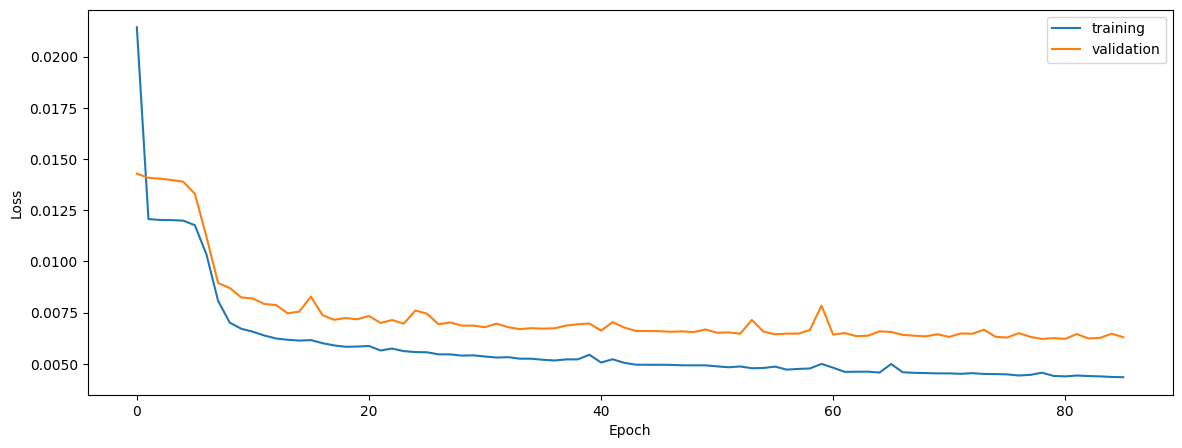

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7993770758229526
0.7431923695944239
0.7861094902483152


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7993770758229526
0.7431923695944239
0.7861094902483152


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8006150676842037
0.7420894337671117
0.8082377980446095


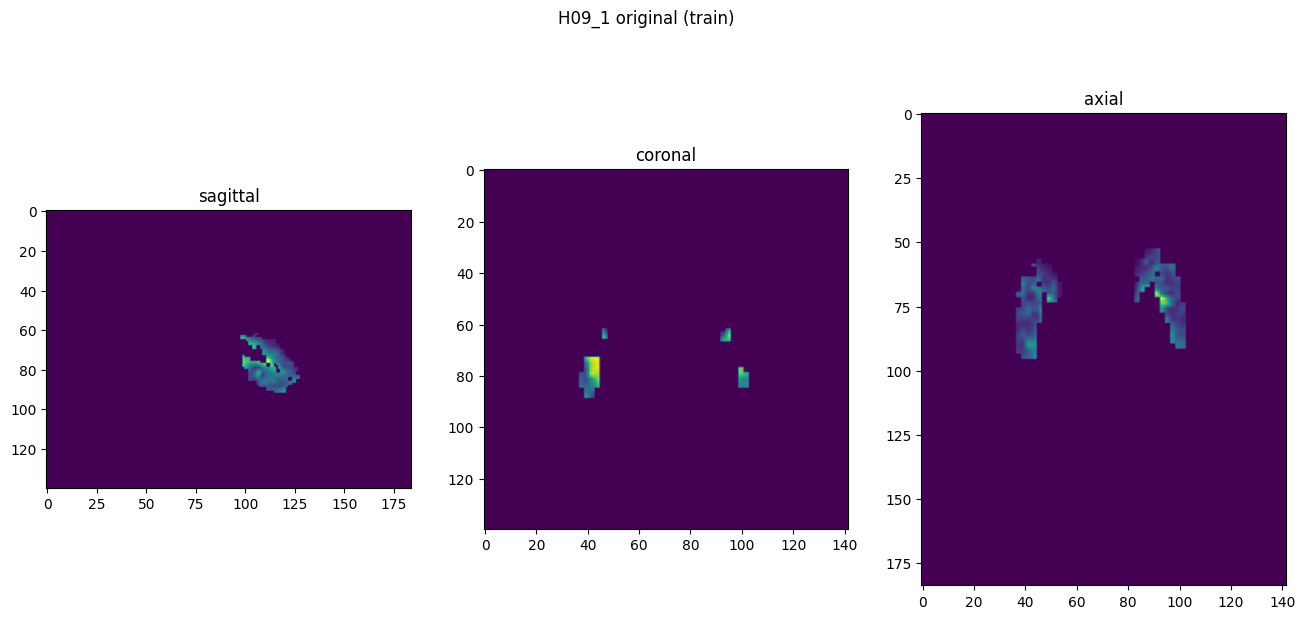

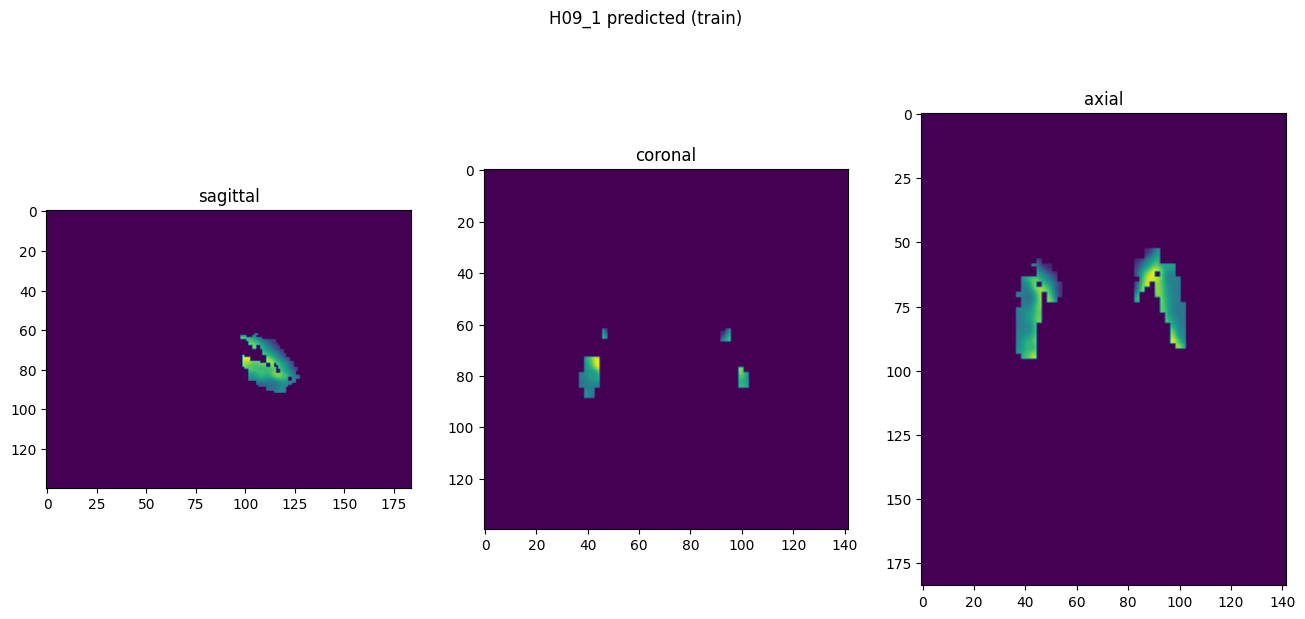

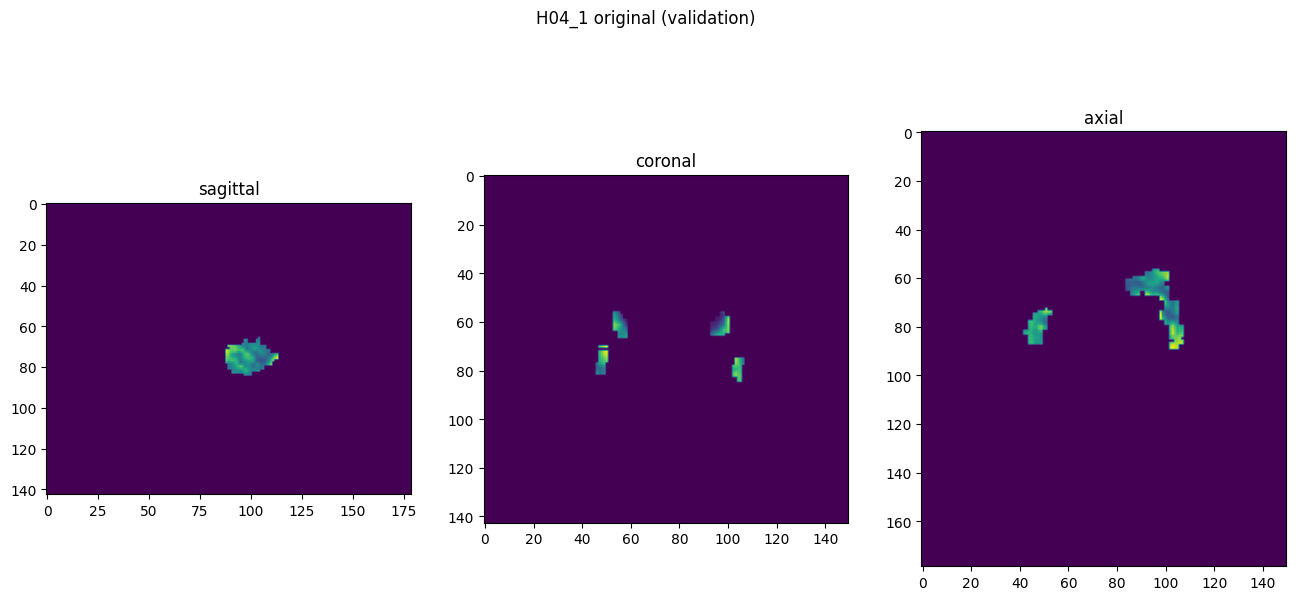

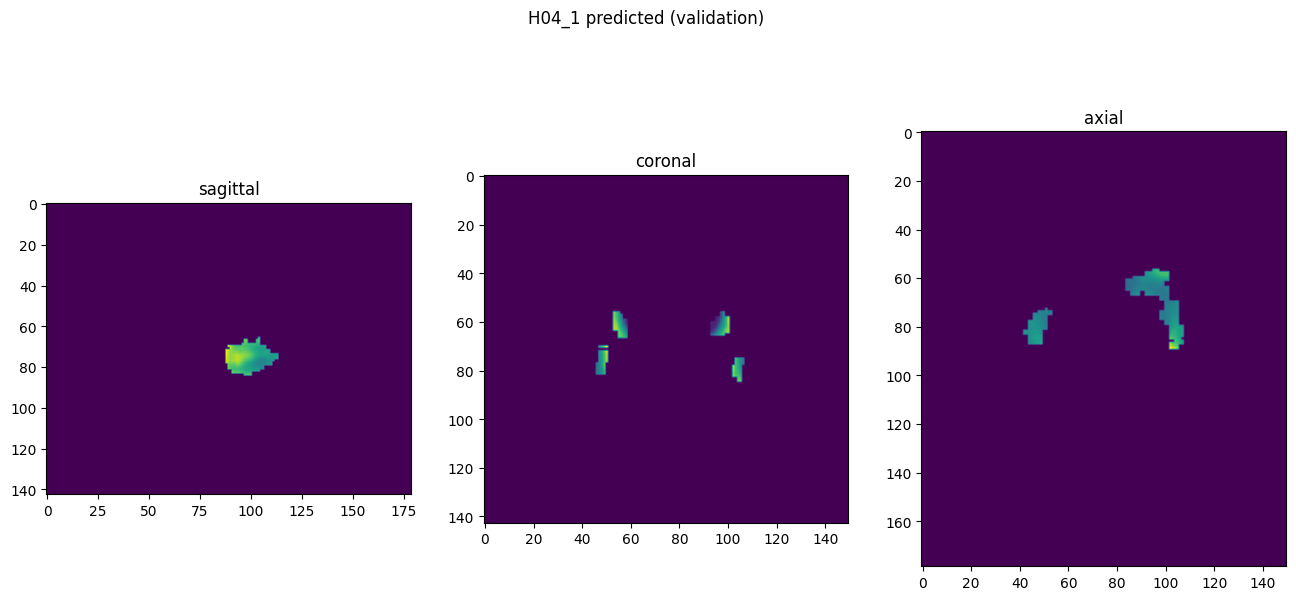

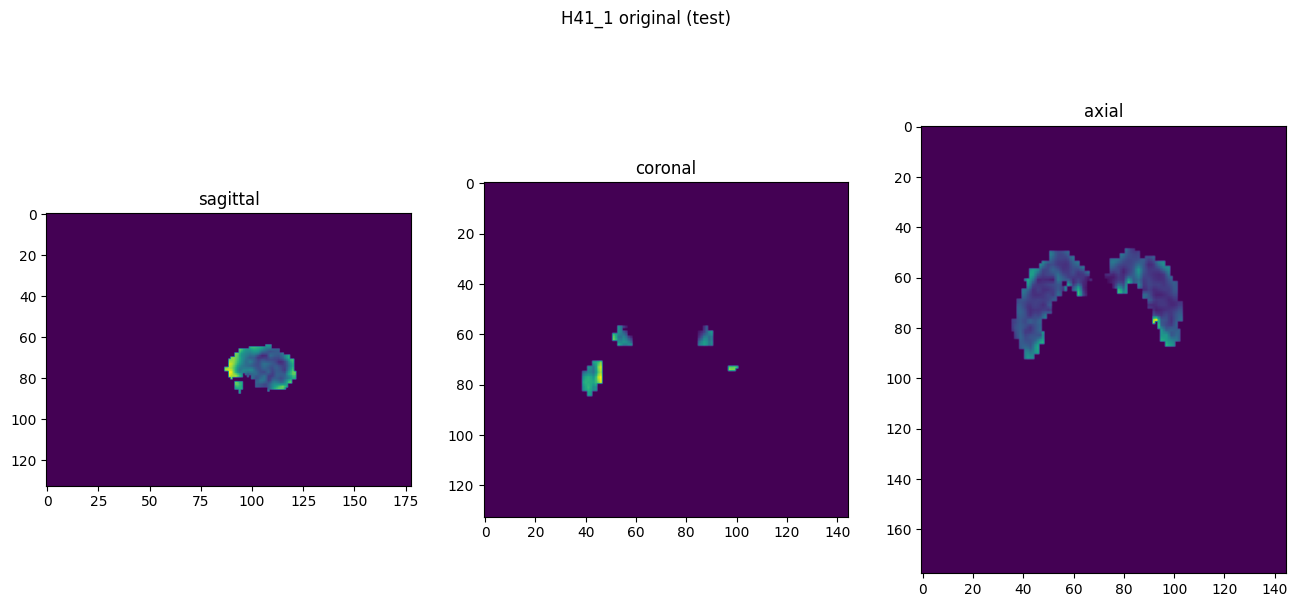

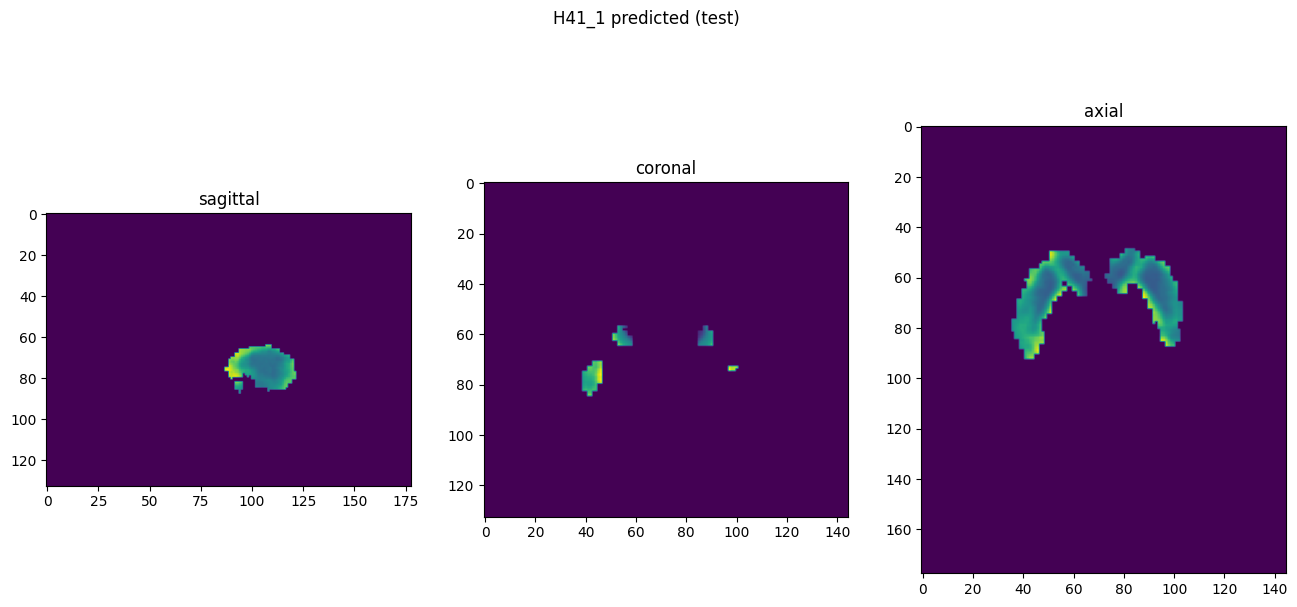

In [10]:
showResults(model, gen, threshold=None, background=False)